In [1]:
import gurobipy

In [2]:
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import country_converter as coco
import pypsa
import rasterio.crs as crs
import os

In [3]:
# Projection to use for all calculations
# ESRI:102033: South_America_Albers_Equal_Area_Conic
c = "EPSG:4326"

### Splitting Chile into regions

In [4]:

chile_regions = gpd.read_file("./data/chile_regions.gpkg")
chile_regions.drop(["GID_0", "GID_1", "COUNTRY"],axis=1)
chile_regions = chile_regions.to_crs(c)

In [5]:
from sklearn.cluster import AgglomerativeClustering

In [6]:
def aggregate_regions(geodataframe, num_regions):
    # use clustering algorithms K-means to create clusters
    ## extract coordinates for KMeans clustering
    coords = np.array(list(geodataframe.geometry.centroid.apply(lambda point: [point.x, point.y])))
    ## create clusters of regions
    # Create clusters of regions using Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=num_regions)
    geodataframe["cluster"] = agglomerative.fit_predict(coords)

    # aggregate regions by clusters
    geodataframe = geodataframe.dissolve(by="cluster")
#    geodataframe.NAME_1 =  [
#    "Southern Chile",
#    'Atacama',
#    'Central Chile incl. Santiago',
#    'Central Northern Chile',
#    'Central Southern Chile'
#]
    geodataframe.NAME_1 = ["CHL1", "CHL2", "CHL3", "CHL4", "CHL5"]
    geodataframe = geodataframe.loc[:, ["NAME_1", "geometry"]].set_index('NAME_1')
    
    return geodataframe

In [7]:
aggregated_regions = aggregate_regions(chile_regions.to_crs(c), 5)

C:\Users\phamt\AppData\Local\Temp\ipykernel_8608\666781972.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [8]:
aggregated_regions

,geometry
NAME_1,
CHL1,"MULTIPOLYGON (((-75.61368 -49.85324, -75.61456..."
CHL2,"MULTIPOLYGON (((-70.69997 -25.89342, -70.70020..."
CHL3,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."
CHL4,"MULTIPOLYGON (((-71.53570 -32.16451, -71.53576..."
CHL5,"MULTIPOLYGON (((-74.73901 -43.52268, -74.73918..."


In [9]:
def get_country_economic_zone(EEZ, country):
    """extract the Exclusive Economic Zone (EEZ) for a chosen country
    INPUT:  EEZ                 - GeoDataFrame of EEZ
            country             - Name of the country in string
    OUTPUT: gpd.GeoDataFrame    - GeoDataFrame of the country's EEZ
    """
    return EEZ.query(f"SOVEREIGN1 == '{country}'")

In [10]:
# load Exclusive economic zones
EEZ_boundaries = gpd.read_file("./data/EEZ_boundaries.gpkg")
EEZ = gpd.read_file("./data/EEZ.gpkg")

In [11]:
# Exclusive economic zone of Chile
## extract Chile's EEZ
chile_EEZ = get_country_economic_zone(EEZ, "Chile").to_crs(c)
chile_EEZ = chile_EEZ.rename(columns = {"GEONAME":"NAME_1"}).loc[:, ["NAME_1", "geometry"]].set_index("NAME_1")

In [12]:
chile_EEZ = chile_EEZ.iloc[:-1]

In [13]:
chile_EEZ = chile_EEZ.iloc[:-1]

In [14]:
chile_regions = pd.concat([chile_regions.to_crs(c), chile_EEZ.to_crs(c)])
# drop 2 islands of EEZ


# update the last row for 1 Chile EEZ
chile_regions.loc[chile_regions.index[-1], 'NAME_1'] = "Chilean Exclusive Economic Zone"
chile_regions.drop(chile_regions[chile_regions["NAME_1"] == "Chilean Exclusive Economic Zone"].index, inplace=True)

In [15]:
## combine Chile aggregated regions and EEZ
aggregated_regionsEEZ = pd.concat([aggregated_regions, chile_EEZ])

In [16]:
aggregated_regionsEEZ

,geometry
NAME_1,
CHL1,"MULTIPOLYGON (((-75.61368 -49.85324, -75.61456..."
CHL2,"MULTIPOLYGON (((-70.69997 -25.89342, -70.70020..."
CHL3,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."
CHL4,"MULTIPOLYGON (((-71.53570 -32.16451, -71.53576..."
CHL5,"MULTIPOLYGON (((-74.73901 -43.52268, -74.73918..."
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-70.93199 -54.75580, -70.92427..."


In [17]:
chile_regions1 = pd.concat([chile_regions.to_crs(c), chile_EEZ.to_crs(c)])
# drop 2 islands of EEZ
chile_regions1.drop(chile_regions1.tail(2).index,inplace=True) 
chile_regions1 = chile_regions1.reset_index()

# update the last row for 1 Chile EEZ
chile_regions1.loc[chile_regions1.index[-1], 'index'] = 16
chile_regions1.loc[chile_regions1.index[-1], 'GID_0'] = "CHL"
chile_regions1.loc[chile_regions1.index[-1], 'GID_1'] = "CHL.17_1"
chile_regions1.loc[chile_regions1.index[-1], 'COUNTRY'] = "Chile"
chile_regions1.loc[chile_regions1.index[-1], 'NAME_1'] = "Chilean Exclusive Economic Zone"
chile_regions1.drop(chile_regions1[chile_regions1["NAME_1"] == "Chilean Exclusive Economic Zone"].index, inplace=True)

In [22]:
aggregated_regions

,geometry
NAME_1,
CHL1,MULTIPOLYGON (((-75.61367999999999 -49.8532429...
CHL2,MULTIPOLYGON (((-70.69997097399994 -25.8934183...
CHL3,MULTIPOLYGON (((-109.45239856199998 -27.200558...
CHL4,MULTIPOLYGON (((-71.53570353399988 -32.1645074...
CHL5,MULTIPOLYGON (((-74.73901099999989 -43.5226779...


#### # Create converter DF: 

In [19]:
# Create converter DF: 
regions_converter = gpd.sjoin(chile_regions1,aggregated_regions,how="left",op="within")

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [24]:
regions_converter = regions_converter.drop(["GID_0", "GID_1", "COUNTRY"],axis=1)
regions_converter.rename(columns={'NAME_1': 'Regions'}, inplace=True)
regions_converter.reset_index(inplace=True)
regions_converter.rename(columns={'index_right': 'aggRegions'}, inplace=True)

In [25]:
regions_converter

,level_0,index,Regions,geometry,aggRegions
0,0,0,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2
1,1,1,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5
2,2,2,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2
3,3,3,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4
4,4,4,Aysén del General Ibañez del Cam,"MULTIPOLYGON (((-75.57556 -48.75867, -75.57551...",CHL1
5,5,5,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3
6,6,6,Coquimbo,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525...",CHL4
7,7,7,Libertador General Bernardo O'Hi,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867...",CHL3
8,8,8,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5
9,9,9,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5


In [26]:
regions_converter = regions_converter.drop(["level_0", "index"],axis=1)

## Adding Generators

#### Add Costs

In [27]:
# technology
year = 2050
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])
costs

value  \
technology                        parameter                      
Ammonia cracker                   FOM                   4.3000   
                                  ammonia-input         1.4600   
                                  investment       527592.2200   
                                  lifetime             25.0000   
Battery electric (passenger cars) FOM                   0.9000   
...                                                        ...   
waste CHP CC                      efficiency-heat       0.7625   
                                  investment         7068.8867   
                                  lifetime             25.0000   
water tank charger                efficiency            0.8367   
water tank discharger             efficiency            0.8367   

                                                             unit  \
technology                        parameter                         
Ammonia cracker                   FOM                      %/year   
                                  ammonia-input    MWh_NH3/MWh_H2   
                                  investment            EUR/MW_H2   
                                  lifetime                  years   
Battery electric (passenger cars) FOM                           %   
...                                                           ...   
waste CHP CC                      efficiency-heat        per unit   
                                  investment             EUR/kW_e   
                                  lifetime                  years   
water tank charger                efficiency             per unit   
water tank discharger             efficiency             per unit   

                                                                                              source  \
technology                        parameter                                                            
Ammonia cracker                   FOM              Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
                                  ammonia-input    ENGIE et al (2020): Ammonia to Green Hydrogen ...   
                                  investment       Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
                                  lifetime         Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
Battery electric (passenger cars) FOM              PATHS TO A CLIMATE-NEUTRAL ENERGY SYSTEM The G...   
...                                                                                              ...   
waste CHP CC                      efficiency-heat  Danish Energy Agency, technology_data_for_el_a...   
                                  investment       Danish Energy Agency, technology_data_for_el_a...   
                                  lifetime         Danish Energy Agency, technology_data_for_el_a...   
water tank charger                efficiency       Danish Energy Agency, technology_data_catalogu...   
water tank discharger             efficiency       Danish Energy Agency, technology_data_catalogu...   

                                                                                 further description  
technology                        parameter                                                           
Ammonia cracker                   FOM              Estimated based on Labour cost rate, Maintenan...  
                                  ammonia-input    Assuming a integrated 200t/d cracking and puri...  
                                  investment       Calculated. For a small (200 t_NH3/d input) fa...  
                                  lifetime                                                       NaN  
Battery electric (passenger cars) FOM                              Battery electric (passenger cars)  
...                                                                                              ...  
waste CHP CC                      efficiency-heat  08 WtE CHP, Large, 50 degree:  Heat efficiency...  
                    

In [28]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

In [29]:
# Question: Why Petcoke = Gas? Rather Oil
costs.at["petcoke", "fuel"] = costs.at["oil", "fuel"]
costs.at["petcoke", "fuel"] = costs.at["oil", "fuel"]
costs.at["petcoke", "CO2 intensity"] = costs.at["oil", "CO2 intensity"]
costs.at["petcoke", "CO2 intensity"] = costs.at["oil", "CO2 intensity"]

In [30]:
# Annuity
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [31]:
# Marginal cost,  €/MWh
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"] 

In [32]:
# Capital cost, €/MW/a
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

### Add Power  Plants

In [33]:
# Add the fleet of existing power plants
pwp = pd.read_csv(".\data\global_power_plant_database.csv", index_col=0, parse_dates=True)

C:\Users\phamt\AppData\Local\Temp\ipykernel_8608\2726276955.py:2: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\phamt\AppData\Local\Temp\ipykernel_8608\2726276955.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [34]:
# Power plants in Chile
geometry = gpd.points_from_xy(pwp["longitude"], pwp["latitude"])
pwp_gdf = gpd.GeoDataFrame(pwp, geometry=geometry, crs=c)
pwp_chile = pwp_gdf.query("country_long =='Chile'")
pwp_chile = pwp_chile.set_geometry('geometry')

In [35]:
# Disregard existing wind and solar capacities
pwp_chile = pwp_chile[~pwp_chile['primary_fuel'].isin(['Wind', 'Solar'])]

In [37]:
aggregated_regions

,geometry
NAME_1,
CHL1,MULTIPOLYGON (((-75.61367999999999 -49.8532429...
CHL2,MULTIPOLYGON (((-70.69997097399994 -25.8934183...
CHL3,MULTIPOLYGON (((-109.45239856199998 -27.200558...
CHL4,MULTIPOLYGON (((-71.53570353399988 -32.1645074...
CHL5,MULTIPOLYGON (((-74.73901099999989 -43.5226779...


In [38]:
regions_converter = regions_converter.to_crs(c)
pwp_chile = pwp_chile .to_crs(c)

### Aggregate fossil power plants over different plants of the same type

In [39]:
### Joining Powerplant, Cost and Geographic DataFrames
# 14 regions
pwp_chile = gpd.sjoin(pwp_chile,chile_regions, how='left', op='within')

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [40]:
pwp_chile["p_max_pu"] = pwp_chile.estimated_generation_gwh_2017*(1e3)/8760/pwp_chile.capacity_mw
pwp_chile.head()

,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,...,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry,index_right,GID_0,GID_1,COUNTRY,NAME_1,p_max_pu
country,,,,,,,,,,,,,,,,,,,,,
CHL,Chile,ABANICO,CHL0001001,136.0,-37.3646,-71.4894,Hydro,NaN,NaN,NaN,...,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-71.48940 -37.36460),5.0,CHL,CHL.6_1,Chile,Bío-Bío,0.333266
CHL,Chile,AGUAS BLANCAS,CHL0000001,2.0,-24.1355,-69.8649,Oil,NaN,NaN,NaN,...,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-69.86490 -24.13550),0.0,CHL,CHL.2_1,Chile,Antofagasta,0.066781
CHL,Chile,ALFALFAL,CHL0001002,178.0,-33.5012,-70.1927,Hydro,NaN,NaN,NaN,...,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-70.19270 -33.50120),13.0,CHL,CHL.14_1,Chile,Santiago Metropolitan,0.340965
CHL,Chile,ALLIPEN,CHL0001003,3.0,-38.9987,-72.2230,Hydro,NaN,NaN,NaN,...,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-72.22300 -38.99870),1.0,CHL,CHL.3_1,Chile,Araucanía,0.445586
CHL,Chile,ANGOL (LOS SAUCES),CHL0000134,1.5,-37.9658,-72.8269,Oil,NaN,NaN,NaN,...,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-72.82690 -37.96580),1.0,CHL,CHL.3_1,Chile,Araucanía,0.066210


In [41]:
pwp_chile["Weighted_Regional_Capacity"] = 0
grouped_sum = pwp_chile.groupby(["NAME_1", "primary_fuel"])["capacity_mw"].transform('sum')
pwp_chile["Weighted_Regional_Capacity"] = (pwp_chile['p_max_pu'] * pwp_chile['capacity_mw']) / grouped_sum
pwp_chile["Weighted_Regional_Capacity"]

country
CHL    0.015864
CHL    0.000966
CHL    0.163150
CHL    0.037132
CHL    0.007197
         ...   
CHL    0.010559
CHL    0.208233
CHL    0.015073
CHL    0.001236
CHL    0.028111
Name: Weighted_Regional_Capacity, Length: 220, dtype: float64

#### Aggregate Capacity Factors

In [42]:
# Aggregate Capacity Factors
aggregated_plants_cf = pwp_chile.groupby(["NAME_1","primary_fuel"])["Weighted_Regional_Capacity"].sum().unstack().fillna(0)
aggregated_plants_capacity = pwp_chile.groupby(["NAME_1","primary_fuel"])["capacity_mw"].sum().unstack().fillna(0)
aggregated_plants_capacity

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
NAME_1,,,,,,
Antofagasta,0.0,747.6000,1012.200000,0.0,138.200000,0.0000
Araucanía,81.0,0.0000,0.000000,36.0,13.800000,0.0000
Arica y Parinacota,0.0,0.0000,0.000000,10.0,14.200000,0.0000
Atacama,0.0,760.0000,0.000000,5.0,511.301450,0.0000
Bío-Bío,168.2,819.9910,61.157689,2857.0,473.049478,62.9775
Coquimbo,0.0,0.0000,0.000000,29.0,354.647000,0.0000
Libertador General Bernardo O'Hi,15.6,0.0000,253.900000,949.0,43.400000,0.0000
Los Lagos,0.0,0.0000,0.000000,288.0,161.600000,0.0000
Los Ríos,0.0,0.0000,0.000000,122.0,117.200000,0.0000


In [43]:
aggregated_plants_cf.reset_index(inplace=True)
aggregated_plants_capacity.reset_index(inplace=True)

In [44]:
# ### Collapse Aggregated_Plants Data to five region level
aggregated_plants_cf = pd.merge(aggregated_plants_cf, chile_regions1, on="NAME_1", how="inner")
aggregated_plants_capacity = pd.merge(aggregated_plants_capacity, chile_regions1, on="NAME_1", how="inner")

In [45]:
aggregated_plants_capacity

,NAME_1,Biomass,Coal,Gas,Hydro,Oil,Petcoke,index,GID_0,GID_1,COUNTRY,geometry
0,Antofagasta,0.0,747.600,1012.200000,0.0,138.200000,0.0000,0,CHL,CHL.2_1,Chile,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984..."
1,Araucanía,81.0,0.000,0.000000,36.0,13.800000,0.0000,1,CHL,CHL.3_1,Chile,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437..."
2,Arica y Parinacota,0.0,0.000,0.000000,10.0,14.200000,0.0000,2,CHL,CHL.4_1,Chile,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175..."
3,Atacama,0.0,760.000,0.000000,5.0,511.301450,0.0000,3,CHL,CHL.5_1,Chile,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112..."
4,Bío-Bío,168.2,819.991,61.157689,2857.0,473.049478,62.9775,5,CHL,CHL.6_1,Chile,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726..."
5,Coquimbo,0.0,0.000,0.000000,29.0,354.647000,0.0000,6,CHL,CHL.7_1,Chile,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525..."
6,Libertador General Bernardo O'Hi,15.6,0.000,253.900000,949.0,43.400000,0.0000,7,CHL,CHL.8_1,Chile,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867..."
7,Los Lagos,0.0,0.000,0.000000,288.0,161.600000,0.0000,8,CHL,CHL.9_1,Chile,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973..."
8,Los Ríos,0.0,0.000,0.000000,122.0,117.200000,0.0000,9,CHL,CHL.10_1,Chile,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676..."
9,Maule,14.0,2.000,0.000000,1592.0,87.414000,0.0000,11,CHL,CHL.12_1,Chile,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669..."


In [46]:
aggregated_plants_cf = gpd.GeoDataFrame(aggregated_plants_cf,geometry=aggregated_plants_cf["geometry"],crs=c)

In [47]:
aggregated_plants_capacity = gpd.GeoDataFrame(aggregated_plants_capacity,geometry=aggregated_plants_capacity["geometry"],crs=c)

In [48]:
aggregated_plants_cf.drop(columns="GID_0",inplace=True)
aggregated_plants_cf.drop(columns="GID_1",inplace=True)
aggregated_plants_cf.drop(columns="index",inplace=True)
aggregated_plants_cf.drop(columns="COUNTRY",inplace=True)
aggregated_plants_capacity.drop(columns="GID_0",inplace=True)
aggregated_plants_capacity.drop(columns="GID_1",inplace=True)
aggregated_plants_capacity.drop(columns="index",inplace=True)
aggregated_plants_capacity.drop(columns="COUNTRY",inplace=True)

In [53]:
if not isinstance(aggregated_regions['geometry'], gpd.GeoSeries):
    aggregated_regions['geometry'] = gpd.GeoSeries.from_wkt(aggregated_regions['geometry'])

aggregated_regions = gpd.GeoDataFrame(aggregated_regions, geometry='geometry')

if aggregated_regions.crs is None:
    aggregated_regions.crs = "EPSG:4326"

aggregated_regions = aggregated_regions.to_crs(c)

In [54]:
aggregated_regions

,geometry
NAME_1,
CHL1,"MULTIPOLYGON (((-75.61368 -49.85324, -75.61456..."
CHL2,"MULTIPOLYGON (((-70.69997 -25.89342, -70.70020..."
CHL3,"MULTIPOLYGON (((-109.45240 -27.20056, -109.452..."
CHL4,"MULTIPOLYGON (((-71.53570 -32.16451, -71.53576..."
CHL5,"MULTIPOLYGON (((-74.73901 -43.52268, -74.73918..."


In [55]:
# Merge Capacity Factor to Aggregated Regions'
aggregated_plants_cf_merged = gpd.sjoin(aggregated_plants_cf, regions_converter, op='within')

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [56]:
aggregated_plants_cf_merged.drop(columns="index_right",inplace=True)

In [57]:
aggregated_plants_cf_merged.drop(columns="Regions",inplace=True)

In [58]:
aggregated_plants_cf_merged

,NAME_1,Biomass,Coal,Gas,Hydro,Oil,Petcoke,geometry,aggRegions
0,Antofagasta,0.0,0.629793,0.455398,0.000000,0.066775,0.0,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2
1,Araucanía,0.0,0.000000,0.000000,0.385052,0.066508,0.0,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5
2,Arica y Parinacota,0.0,0.000000,0.000000,0.298630,0.066725,0.0,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2
3,Atacama,0.0,0.629793,0.000000,0.293836,0.066785,0.0,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4
4,Bío-Bío,0.0,0.629793,0.455369,0.332817,0.066785,0.0,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3
5,Coquimbo,0.0,0.000000,0.000000,0.309085,0.066781,0.0,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525...",CHL4
6,Libertador General Bernardo O'Hi,0.0,0.000000,0.455398,0.351177,0.066757,0.0,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867...",CHL3
7,Los Lagos,0.0,0.000000,0.000000,0.373989,0.066748,0.0,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5
8,Los Ríos,0.0,0.000000,0.000000,0.389616,0.066779,0.0,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5
9,Maule,0.0,0.629566,0.000000,0.342645,0.066771,0.0,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",CHL3


In [59]:
# Merge Capacity to 5 Aggregated Regions of Interest
aggregated_plants_capacity_merged = gpd.sjoin(aggregated_plants_capacity, regions_converter, op='within')

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [60]:
aggregated_plants_capacity_merged = aggregated_plants_capacity_merged.drop("Regions",axis=1)

In [61]:
aggregated_plants_capacity_merged = pd.melt(aggregated_plants_capacity_merged, 
                     id_vars=['NAME_1', 'geometry', 'aggRegions'], 
                     var_name='primary_fuel', 
                     value_name='Capacity')

In [62]:
aggregated_plants_capacity_merged

,NAME_1,geometry,aggRegions,primary_fuel,Capacity
0,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2,Biomass,0.0
1,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5,Biomass,81.0
2,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2,Biomass,0.0
3,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4,Biomass,0.0
4,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3,Biomass,168.2
...,...,...,...,...,...
79,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5,index_right,8.0
80,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5,index_right,9.0
81,Maule,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",CHL3,index_right,11.0
82,Santiago Metropolitan,"MULTIPOLYGON (((-70.97122 -34.17239, -70.97164...",CHL3,index_right,13.0


In [63]:
aggregated_plants_cf_merged

,NAME_1,Biomass,Coal,Gas,Hydro,Oil,Petcoke,geometry,aggRegions
0,Antofagasta,0.0,0.629793,0.455398,0.000000,0.066775,0.0,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2
1,Araucanía,0.0,0.000000,0.000000,0.385052,0.066508,0.0,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5
2,Arica y Parinacota,0.0,0.000000,0.000000,0.298630,0.066725,0.0,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2
3,Atacama,0.0,0.629793,0.000000,0.293836,0.066785,0.0,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4
4,Bío-Bío,0.0,0.629793,0.455369,0.332817,0.066785,0.0,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3
5,Coquimbo,0.0,0.000000,0.000000,0.309085,0.066781,0.0,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525...",CHL4
6,Libertador General Bernardo O'Hi,0.0,0.000000,0.455398,0.351177,0.066757,0.0,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867...",CHL3
7,Los Lagos,0.0,0.000000,0.000000,0.373989,0.066748,0.0,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5
8,Los Ríos,0.0,0.000000,0.000000,0.389616,0.066779,0.0,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5
9,Maule,0.0,0.629566,0.000000,0.342645,0.066771,0.0,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",CHL3


In [64]:
# Melt Capacity Factors
aggregated_plants_cf_merged = pd.melt(aggregated_plants_cf_merged, id_vars=['NAME_1', 'geometry', "aggRegions"],
                    value_vars=['Biomass', 'Coal', 'Gas', 'Hydro', 'Oil', 'Petcoke'],
                    var_name='primary_fuel', value_name='p_max_pu')

In [65]:
aggregated_plants_cf_merged[aggregated_plants_cf_merged["primary_fuel"]=="Coal"]

,NAME_1,geometry,aggRegions,primary_fuel,p_max_pu
12,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2,Coal,0.629793
13,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5,Coal,0.000000
14,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2,Coal,0.000000
15,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4,Coal,0.629793
16,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3,Coal,0.629793
17,Coquimbo,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525...",CHL4,Coal,0.000000
18,Libertador General Bernardo O'Hi,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867...",CHL3,Coal,0.000000
19,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5,Coal,0.000000
20,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5,Coal,0.000000
21,Maule,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",CHL3,Coal,0.629566


In [66]:
aggregated_plants_cf_merged

,NAME_1,geometry,aggRegions,primary_fuel,p_max_pu
0,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2,Biomass,0.0
1,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5,Biomass,0.0
2,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2,Biomass,0.0
3,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4,Biomass,0.0
4,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3,Biomass,0.0
...,...,...,...,...,...
67,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5,Petcoke,0.0
68,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5,Petcoke,0.0
69,Maule,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",CHL3,Petcoke,0.0
70,Santiago Metropolitan,"MULTIPOLYGON (((-70.97122 -34.17239, -70.97164...",CHL3,Petcoke,0.0


In [67]:
aggregated_plants_cf.rename(columns={"NAME_1_right": "NAME_1"}, inplace=True)
aggregated_plants_capacity.rename(columns={"NAME_1_left": "NAME_1"}, inplace=True)

In [68]:
aggregated_plants_capacity

,NAME_1,Biomass,Coal,Gas,Hydro,Oil,Petcoke,geometry
0,Antofagasta,0.0,747.600,1012.200000,0.0,138.200000,0.0000,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984..."
1,Araucanía,81.0,0.000,0.000000,36.0,13.800000,0.0000,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437..."
2,Arica y Parinacota,0.0,0.000,0.000000,10.0,14.200000,0.0000,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175..."
3,Atacama,0.0,760.000,0.000000,5.0,511.301450,0.0000,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112..."
4,Bío-Bío,168.2,819.991,61.157689,2857.0,473.049478,62.9775,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726..."
5,Coquimbo,0.0,0.000,0.000000,29.0,354.647000,0.0000,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525..."
6,Libertador General Bernardo O'Hi,15.6,0.000,253.900000,949.0,43.400000,0.0000,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867..."
7,Los Lagos,0.0,0.000,0.000000,288.0,161.600000,0.0000,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973..."
8,Los Ríos,0.0,0.000,0.000000,122.0,117.200000,0.0000,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676..."
9,Maule,14.0,2.000,0.000000,1592.0,87.414000,0.0000,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669..."


In [69]:
aggregated_plants_merged = pd.merge(aggregated_plants_cf_merged,aggregated_plants_capacity_merged,on=['NAME_1', 'geometry', 'aggRegions', "primary_fuel"], how='inner')

In [70]:
aggregated_plants_merged

,NAME_1,geometry,aggRegions,primary_fuel,p_max_pu,Capacity
0,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2,Biomass,0.0,0.0
1,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5,Biomass,0.0,81.0
2,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2,Biomass,0.0,0.0
3,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4,Biomass,0.0,0.0
4,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3,Biomass,0.0,168.2
...,...,...,...,...,...,...
67,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5,Petcoke,0.0,0.0
68,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5,Petcoke,0.0,0.0
69,Maule,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",CHL3,Petcoke,0.0,0.0
70,Santiago Metropolitan,"MULTIPOLYGON (((-70.97122 -34.17239, -70.97164...",CHL3,Petcoke,0.0,0.0


In [71]:
aggregated_plants_merged["Weighted_Agg_CF"] = 0

In [72]:
aggregated_plants_merged

,NAME_1,geometry,aggRegions,primary_fuel,p_max_pu,Capacity,Weighted_Agg_CF
0,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2,Biomass,0.0,0.0,0
1,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5,Biomass,0.0,81.0,0
2,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2,Biomass,0.0,0.0,0
3,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4,Biomass,0.0,0.0,0
4,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3,Biomass,0.0,168.2,0
...,...,...,...,...,...,...,...
67,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5,Petcoke,0.0,0.0,0
68,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5,Petcoke,0.0,0.0,0
69,Maule,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",CHL3,Petcoke,0.0,0.0,0
70,Santiago Metropolitan,"MULTIPOLYGON (((-70.97122 -34.17239, -70.97164...",CHL3,Petcoke,0.0,0.0,0


In [73]:
grouped_sum = aggregated_plants_merged.groupby(["aggRegions", "primary_fuel"])["Capacity"].transform('sum')
aggregated_plants_merged["Weighted_Agg_CF"] = (aggregated_plants_merged['p_max_pu'] * aggregated_plants_merged['Capacity']) / grouped_sum

In [74]:
aggregated_plants_merged["Weighted_Agg_CF"] = (
    aggregated_plants_merged['p_max_pu'] * aggregated_plants_merged['Capacity'] /
    grouped_sum.where(grouped_sum != 0, 1)  # Replace zero with 1 to avoid division by zero
)

In [75]:
aggregated_plants_merged[aggregated_plants_merged["primary_fuel"]=="Coal"]

,NAME_1,geometry,aggRegions,primary_fuel,p_max_pu,Capacity,Weighted_Agg_CF
12,Antofagasta,"MULTIPOLYGON (((-70.69986 -25.89208, -70.69984...",CHL2,Coal,0.629793,747.600,0.629793
13,Araucanía,"MULTIPOLYGON (((-71.43538 -38.98652, -71.43437...",CHL5,Coal,0.000000,0.000,0.000000
14,Arica y Parinacota,"MULTIPOLYGON (((-69.28189 -17.96854, -69.28175...",CHL2,Coal,0.000000,0.000,0.000000
15,Atacama,"MULTIPOLYGON (((-71.26113 -28.49285, -71.26112...",CHL4,Coal,0.629793,760.000,0.629793
16,Bío-Bío,"MULTIPOLYGON (((-73.94790 -38.31745, -73.94726...",CHL3,Coal,0.629793,819.991,0.628261
17,Coquimbo,"MULTIPOLYGON (((-70.54495 -31.31045, -70.54525...",CHL4,Coal,0.000000,0.000,0.000000
18,Libertador General Bernardo O'Hi,"MULTIPOLYGON (((-71.54829 -34.87441, -71.54867...",CHL3,Coal,0.000000,0.000,0.000000
19,Los Lagos,"MULTIPOLYGON (((-74.73979 -43.51976, -74.73973...",CHL5,Coal,0.000000,0.000,0.000000
20,Los Ríos,"MULTIPOLYGON (((-71.88819 -40.55778, -71.88676...",CHL5,Coal,0.000000,0.000,0.000000
21,Maule,"MULTIPOLYGON (((-71.52672 -34.87628, -71.52669...",CHL3,Coal,0.629566,2.000,0.001532


In [76]:
# Collapse the CF DataFrame doen to 5 regions of interes
aggregated_cf = pd.DataFrame(aggregated_plants_merged.groupby(["aggRegions", "primary_fuel"])["Weighted_Agg_CF"].sum().unstack())
aggregated_cf


primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
aggRegions,,,,,,
CHL2,0.0,0.629793,0.455398,0.298630,0.066770,0.0
CHL3,0.0,0.629793,0.455392,0.341628,0.066784,0.0
CHL4,0.0,0.629793,0.000000,0.306843,0.066783,0.0
CHL5,0.0,0.000000,0.000000,0.379157,0.066749,0.0


In [77]:
aggregated_capacity = aggregated_plants_capacity_merged.groupby(["aggRegions", "primary_fuel"])["Capacity"].sum().unstack()
aggregated_capacity

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke,index_right
aggRegions,,,,,,,
CHL2,0.0,747.600,1012.200000,10.0,152.400000,0.0000,2.0
CHL3,302.9,821.991,315.057689,5770.0,1078.767478,62.9775,48.0
CHL4,0.0,760.000,0.000000,34.0,865.948450,0.0000,9.0
CHL5,81.0,0.000,0.000000,446.0,292.600000,0.0000,18.0


In [78]:
#aggregated_capacity.drop("index",axis=1)
aggregated_capacity.drop("index_right",axis=1)


primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
aggRegions,,,,,,
CHL2,0.0,747.600,1012.200000,10.0,152.400000,0.0000
CHL3,302.9,821.991,315.057689,5770.0,1078.767478,62.9775
CHL4,0.0,760.000,0.000000,34.0,865.948450,0.0000
CHL5,81.0,0.000,0.000000,446.0,292.600000,0.0000


In [79]:

aggregated_capacity

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke,index_right
aggRegions,,,,,,,
CHL2,0.0,747.600,1012.200000,10.0,152.400000,0.0000,2.0
CHL3,302.9,821.991,315.057689,5770.0,1078.767478,62.9775,48.0
CHL4,0.0,760.000,0.000000,34.0,865.948450,0.0000,9.0
CHL5,81.0,0.000,0.000000,446.0,292.600000,0.0000,18.0


In [80]:
aggregated_points = aggregated_regionsEEZ.copy()
aggregated_points = aggregated_points.representative_point()
aggregated_points = aggregated_points.to_crs(c).reset_index()
aggregated_points.columns.values[1] = "geometry"
aggregated_points["longitude"] = aggregated_points["geometry"].x
aggregated_points["latitude"] = aggregated_points["geometry"].y


## Building the model

### Determine the centroids per region

### Visualizing existing Power Plants

In [81]:
aggregated_capacity.reset_index("aggRegions",inplace=True)

In [82]:
aggregated_cf.reset_index("aggRegions",inplace=True)

In [83]:
aggregated_capacity = pd.melt(aggregated_capacity, id_vars="aggRegions",
                                     value_vars=['Biomass', 'Coal', 'Gas', 'Hydro', 'Oil', 'Petcoke'],
                                     var_name='primary_fuel', value_name='Capacity')

In [84]:
aggregated_cf = pd.melt(aggregated_cf, id_vars="aggRegions",
                                     value_vars=['Biomass', 'Coal', 'Gas', 'Hydro', 'Oil', 'Petcoke'],
                                     var_name='primary_fuel', value_name='Capacity Factor')

In [85]:
aggregated_cf.set_index(["aggRegions", "primary_fuel"],inplace=True)

In [86]:
aggregated_capacity.set_index("aggRegions",inplace=True)

In [87]:
aggregated_cfDict = aggregated_cf.to_dict(orient='index')
#aggregated_capacityDict = aggregated_capacity.to_dict(orient="index")

### Build the Model

In [88]:
n = pypsa.Network()
# Add buses with locations according to representative points
for i, row in aggregated_points.iterrows():
    n.add("Bus", row["NAME_1"], x=row["geometry"].x, y=row["geometry"].y)


c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\components.py:3

In [89]:
n.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
CHL1,1.0,,-73.442796,-48.767099,AC,,1.0,0.0,inf,PQ,
CHL2,1.0,,-69.105432,-21.780341,AC,,1.0,0.0,inf,PQ,
CHL3,1.0,,-71.488130,-35.256635,AC,,1.0,0.0,inf,PQ,
CHL4,1.0,,-70.541877,-28.783937,AC,,1.0,0.0,inf,PQ,
CHL5,1.0,,-72.899056,-40.824395,AC,,1.0,0.0,inf,PQ,
Chilean Exclusive Economic Zone,1.0,,-75.695574,-39.101509,AC,,1.0,0.0,inf,PQ,


In [90]:
aggregated_cfDict

{('CHL2', 'Biomass'): {'Capacity Factor': 0.0},
 ('CHL3', 'Biomass'): {'Capacity Factor': 0.0},
 ('CHL4', 'Biomass'): {'Capacity Factor': 0.0},
 ('CHL5', 'Biomass'): {'Capacity Factor': 0.0},
 ('CHL2', 'Coal'): {'Capacity Factor': 0.6297931157481719},
 ('CHL3', 'Coal'): {'Capacity Factor': 0.6297925280864851},
 ('CHL4', 'Coal'): {'Capacity Factor': 0.6297930185051671},
 ('CHL5', 'Coal'): {'Capacity Factor': 0.0},
 ('CHL2', 'Gas'): {'Capacity Factor': 0.4553984764864092},
 ('CHL3', 'Gas'): {'Capacity Factor': 0.45539242765393634},
 ('CHL4', 'Gas'): {'Capacity Factor': 0.0},
 ('CHL5', 'Gas'): {'Capacity Factor': 0.0},
 ('CHL2', 'Hydro'): {'Capacity Factor': 0.29863013698630136},
 ('CHL3', 'Hydro'): {'Capacity Factor': 0.3416278894929687},
 ('CHL4', 'Hydro'): {'Capacity Factor': 0.30684260005372016},
 ('CHL5', 'Hydro'): {'Capacity Factor': 0.37915668448102874},
 ('CHL2', 'Oil'): {'Capacity Factor': 0.06677033521494745},
 ('CHL3', 'Oil'): {'Capacity Factor': 0.06678410502466521},
 ('CHL4',

In [91]:
for region in aggregated_cfDict.keys():
    print(f"Region: {region}, Techs: {list(aggregated_cfDict[region].keys())}")

Region: ('CHL2', 'Biomass'), Techs: ['Capacity Factor']
Region: ('CHL3', 'Biomass'), Techs: ['Capacity Factor']
Region: ('CHL4', 'Biomass'), Techs: ['Capacity Factor']
Region: ('CHL5', 'Biomass'), Techs: ['Capacity Factor']
Region: ('CHL2', 'Coal'), Techs: ['Capacity Factor']
Region: ('CHL3', 'Coal'), Techs: ['Capacity Factor']
Region: ('CHL4', 'Coal'), Techs: ['Capacity Factor']
Region: ('CHL5', 'Coal'), Techs: ['Capacity Factor']
Region: ('CHL2', 'Gas'), Techs: ['Capacity Factor']
Region: ('CHL3', 'Gas'), Techs: ['Capacity Factor']
Region: ('CHL4', 'Gas'), Techs: ['Capacity Factor']
Region: ('CHL5', 'Gas'), Techs: ['Capacity Factor']
Region: ('CHL2', 'Hydro'), Techs: ['Capacity Factor']
Region: ('CHL3', 'Hydro'), Techs: ['Capacity Factor']
Region: ('CHL4', 'Hydro'), Techs: ['Capacity Factor']
Region: ('CHL5', 'Hydro'), Techs: ['Capacity Factor']
Region: ('CHL2', 'Oil'), Techs: ['Capacity Factor']
Region: ('CHL3', 'Oil'), Techs: ['Capacity Factor']
Region: ('CHL4', 'Oil'), Techs: ['Ca

In [92]:
# add generators to model
for region, row in aggregated_capacity.iterrows():
    primary_fuel = row["primary_fuel"]
    capacity = row["Capacity"]
    tech = row["primary_fuel"]
    
    if capacity != 0:
        region_tech_tuple = (region, tech)
        
        if region_tech_tuple in aggregated_cfDict:
            efficiency = aggregated_cfDict[region_tech_tuple]['Capacity Factor']
            p_max_pu = aggregated_cf.at[region_tech_tuple, 'Capacity Factor']
            
            n.add("Generator",
                  f"{region} {tech}",
                  bus=region,
                  carrier=primary_fuel,
                  efficiency=efficiency,
                  p_nom=capacity,
                  capital_cost=0,
                  p_max_pu=p_max_pu,
                  p_nom_extendable=False
                  )
        else:
            print(f"Missing data for region: {region}, tech: {tech}")

In [93]:
n.generators.carrier.unique()

array(['Biomass', 'Coal', 'Gas', 'Hydro', 'Oil', 'Petcoke'], dtype=object)

### Preparing Distances for Transmission Lines

In [94]:
regions = aggregated_regions[['geometry']]
index_values = regions.index[1]

In [95]:
points = regions.representative_point() # Finding representative points

In [96]:
# Finding representative points
points = points.to_crs("ESRI:102033")
distances = pd.concat({k: points.distance(p) for k, p in points.items()}, axis=1).div(1e3)

dict = {1: 'Region 1',
        2: 'Region 2',
        3: 'Region 3',
        4: 'Region 4',
        5: 'Region 5',}

distances.rename(columns=dict, inplace=True)
distances.rename(index=dict, inplace=True)
distances.reset_index(inplace=True)
distances.rename(columns={'NAME_1': 'aggRegion'}, inplace=True)
distances = distances.melt(id_vars='aggRegion', var_name='destination', value_name='distance')

In [97]:
distances = distances.loc[(distances["aggRegion"].str.contains("CHL2")) & (distances["destination"].str.contains("CHL4")) |
            (distances["aggRegion"].str.contains("CHL4")) & (distances["destination"].str.contains("CHL3")) |
              (distances["aggRegion"].str.contains("CHL3")) & (distances["destination"].str.contains("CHL5")) |
               (distances["aggRegion"].str.contains("CHL1")) & (distances["destination"].str.contains("CHL5"))]

In [98]:
# Creating the nested dictionary
nested_dict = {}
for index, row in distances.iterrows():
    region = row['aggRegion']
    destination = row['destination']
    distance = row['distance']
    
    if region not in nested_dict:
        nested_dict[region] = {}
    
    nested_dict[region][destination] = distance

print(nested_dict)

{'CHL4': {'CHL3': 754.8126387801974}, 'CHL2': {'CHL4': 828.7930288722002}, 'CHL1': {'CHL5': 864.0825189206818}, 'CHL3': {'CHL5': 643.4968808948424}}


### Adding Links

In [99]:
for start in nested_dict.keys():
    for destination,distance in nested_dict[start].items():
        if distance!=0:
            n.add(
                "Link",
                f"{start}-{destination}",
                bus0=f"{start}",
                bus1=f"{destination}",
                efficiency=1,
                marginal_cost=0,
                p_min_pu=-1,
                length=distance* 1.5,
                capital_cost=400 * distance * 1.5,
                p_nom_extendable=True,
                carrier="HVAC",
        )

In [100]:
n.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
CHL4-CHL3,CHL4,CHL3,,HVAC,1.0,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHL2-CHL4,CHL2,CHL4,,HVAC,1.0,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHL1-CHL5,CHL1,CHL5,,HVAC,1.0,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
CHL3-CHL5,CHL3,CHL5,,HVAC,1.0,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


#### Adding EEZ 

In [101]:
n.add(
   "Bus","Chile EEZ Offshore")

In [102]:
start = "Chilean Exclusive Economic Zone"
destination = "CHL3"

n.add(
   "Link",
   "Chile EEZ Offshore - CHL3",
    bus0=f"{start}",
    bus1=f"{destination}",
    efficiency=1,
    marginal_cost=0,
    p_min_pu=0,
    length=0,
    capital_cost=0,
    p_nom_extendable=True,
    carrier="HVAC"
)

In [103]:
start = "Chilean Exclusive Economic Zone"
destination = "CHL5"

n.add(
   "Link",
   f"{start}-{destination}",
    bus0=f"{start}",
    bus1=f"{destination}",
    efficiency=1,
    marginal_cost=0,
    p_min_pu=0,
    length=0,
    capital_cost=0,
    p_nom_extendable=True,
    carrier="HVAC"
)

In [104]:
start = "Chilean Exclusive Economic Zone"
destination = "CHL1"

n.add(
   "Link",
   f"{start}-{destination}",
    bus0=f"{start}",
    bus1=f"{destination}",
    efficiency=1,
    marginal_cost=0,
    p_min_pu=0,
    length=0,
    capital_cost=0,
    p_nom_extendable=True,
    carrier="HVAC"
)

(<matplotlib.collections.PatchCollection at 0x2a89ae97fd0>,
 <matplotlib.collections.LineCollection at 0x2a89ae75310>)

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



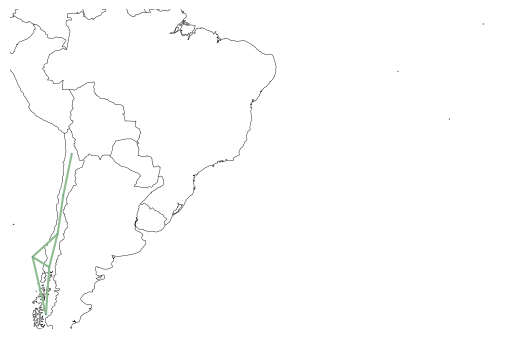

In [105]:
n.plot()

### Adding Population and Regional Demand

In [106]:
population = {
    "Antofagasta": 641, "Araucanía": 1002, "Arica y Parinacota": 247,
    "Atacama": 321, "Aysén del General Ibañez del Cam": 110, "Bío-Bío": 2141,
    "Coquimbo": 794, "Libertador General Bernardo O'Hi": 935, "Los Lagos": 845,
    "Los Ríos": 410, "Magallanes y Antártica Chilena": 166, "Maule": 1058, "Santiago Metropolitan": 7483,
    "Tarapacá": 353, "Valparaíso": 1860, "Nuble": 480, "Los Ríos": 384
    }

population = pd.DataFrame.from_dict(population, orient="index", columns=["regional_population"])
population["percentage"] = population["regional_population"] / population["regional_population"].sum() * 100
population.reset_index(inplace=True)
population.rename(columns={'index': 'NAME_1'}, inplace=True)
population.rename(columns={'NAME_1': 'Regions'}, inplace=True)
population = regions_converter.merge(population, on="Regions",how="right")
population = population.groupby("aggRegions").agg({"percentage": "sum", "regional_population": "sum"})
population["percentage"] = population["percentage"].round()
print(population)

            percentage  regional_population
aggRegions                                 
CHL1               1.0                  276
CHL2               5.0                  888
CHL3              62.0                11617
CHL4               6.0                 1115
CHL5              12.0                 2231


#### Load load Data

In [107]:
fn="./data/load.csv"
ts = pd.read_csv(fn,index_col="time")
ts.index = pd.to_datetime(ts.index)
ts = ts["CL"]
ts = ts.to_frame()
tsindex = ts.index
tsindex = pd.to_datetime(tsindex)
tsindex= tsindex

for i in range(len(population)):
      ts[population.index[i]] = ts["CL"].values * population.iloc[i,0]/100

ts = ts.drop(columns='CL')
ts.head()

,CHL1,CHL2,CHL3,CHL4,CHL5
time,,,,,
2013-01-01 00:00:00,122.735366,613.676831,7609.592710,736.412198,1472.824396
2013-01-01 01:00:00,120.546241,602.731205,7473.866944,723.277446,1446.554892
2013-01-01 02:00:00,115.711293,578.556465,7174.100161,694.267757,1388.535515
2013-01-01 03:00:00,107.151549,535.757746,6643.396046,642.909295,1285.818590
2013-01-01 04:00:00,98.873782,494.368908,6130.174455,593.242689,1186.485378


In [108]:
resolution = 3
ts = ts.resample(f"{resolution}h").mean()
tsDict = ts.to_dict(orient="index")

In [109]:
n.set_snapshots(ts.index)
n.snapshot_weightings.loc[:,:] = resolution
n.snapshot_weightings.head(3)


,objective,stores,generators
snapshot,,,
2013-01-01 00:00:00,3.0,3.0,3.0
2013-01-01 03:00:00,3.0,3.0,3.0
2013-01-01 06:00:00,3.0,3.0,3.0


In [110]:
for timestamp in tsDict.keys():
    for region,load in tsDict[timestamp].items():
        n.add(
            "Load",
            f"Demand {region} {timestamp}",
            bus=f"{region}",
            p_set=load
        )


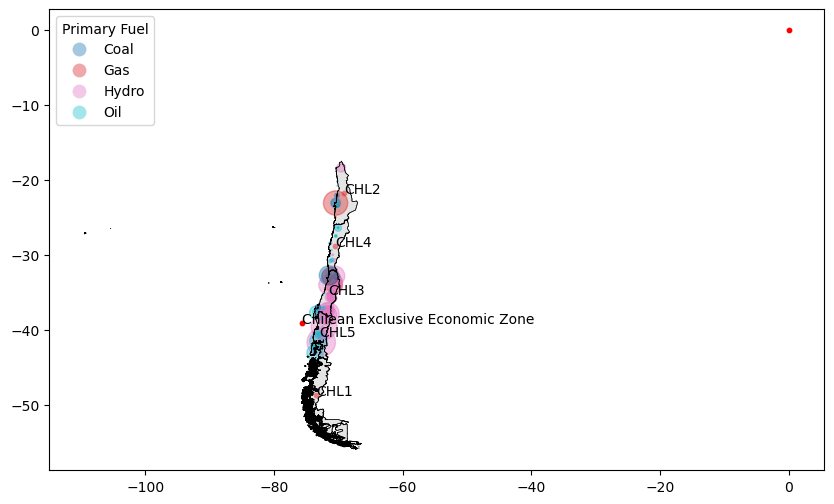

In [111]:
# Convert buses to a GeoDataFrame after the loop
gdf_buses = gpd.GeoDataFrame(n.buses, geometry=gpd.points_from_xy(n.buses.x, n.buses.y))
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 10))

# Plotting
gdf_buses.plot(ax=ax,marker="o", color="red", markersize=10)


# Plot the boundaries of the aggregated regions with a specified line width
aggregated_regions.boundary.plot(ax=ax, color="black", linewidth=0.5)

# Plot the base layer (Chile regions) without specifying the column to use the default geometry
aggregated_regions.plot(ax=ax, color="lightgrey",alpha=0.6)

# Plot the boundaries of the aggregated regions with a specified line width
aggregated_regions.boundary.plot(ax=ax, color="black", linewidth=0.5,alpha=0.6)

# Ensure pwp_chile GeoDataFrame is in the same CRS as aggregated_regions
pwp_chile = pwp_chile.to_crs(aggregated_regions.crs)

for idx, row in aggregated_points.iterrows():
    # Get the centroid of each region
    centroid = row["geometry"]
    # Annotate the plot with the region's NAME_1 at its centroid
    ax.text(centroid.x, centroid.y, row['NAME_1'], fontsize=10, ha='left')

# Plot pwp_chile with size based on estimated generation and color based on primary fuel
pwp_chile[pwp_chile["estimated_generation_gwh_2017"]>0].plot(
    ax=ax,
    column="primary_fuel",
    markersize=pwp_chile['estimated_generation_gwh_2017']/10,  # Adjust as necessary
    legend=True,
    legend_kwds={'title': 'Primary Fuel', 'loc': 'upper left'},
    alpha=0.4
    # Add a legend for primary_fuel categories
    # Color map for primary_fuel categories, adjust as needed
)



plt.show()


### Add Renewable Generation

In [112]:
import pytz

#### Adding Offshore

In [113]:

### Import
fn=r"C:\Users\phamt\Downloads\A_Offshore (1)"
tsOffshore = pd.read_csv(fn)
tsOffshore.index = pd.to_datetime(tsindex)
tsOffshore.index = tsOffshore.index - pd.Timedelta(hours=3)
tsOffshore = tsOffshore.resample(f"{resolution}h").first()


In [114]:
region = "Chilean Exclusive Economic Zone"
n.add("Generator",
    f"{region} OffWind",
    bus=region,
    carrier="offwind",
    p_max_pu=tsOffshore[region],
    marginal_cost=costs.at["offwind", "VOM"],
    capital_cost=costs.at["offwind", "capital_cost"],
    efficiency=costs.at["offwind", "efficiency"]
)
           

#### Adding Onshore Wind

In [115]:
### Import
fn=r"C:\Users\phamt\Downloads\A_Wind (1).csv"
tsOnshore = pd.read_csv(fn)
tsOnshore.index = tsindex
tsOnshore.index = pd.to_datetime(tsindex)
tsOnshore.index = tsOnshore.index - pd.Timedelta(hours=3)
tsOnshore = tsOnshore.resample(f"{resolution}h").first()


In [116]:
for region, data in tsOnshore.items():
    n.add(
        "Generator",
        f"{region} OnWind",
        bus=region,
        carrier="onwind",
        p_max_pu=tsOnshore[region],
        marginal_cost=costs.at["onwind", "VOM"],
        capital_cost=costs.at["onwind", "capital_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

In [117]:
# Function to manually adjust specific timestamps
def adjust_ambiguous_times(index,timestampss):
    adjusted_index = []
    for ts in index:
        # Example: Adjusting a specific ambiguous timestamp
        if ts == pd.Timestamp(timestampss):
            # Adjust by adding an hour, or whatever is appropriate for your data
            adjusted_ts = ts - pd.Timedelta(hours=3)
            adjusted_index.append(adjusted_ts)
        else:
            adjusted_index.append(ts)
    return pd.DatetimeIndex(adjusted_index)

#### Adding Solar Power

In [118]:
fn=r"C:\Users\phamt\Downloads\A_Solar (1).csv"
tsSolar = pd.read_csv(fn)
tsSolar.index = pd.DatetimeIndex(tsindex)
tsSolar.index = tsSolar.index - pd.Timedelta(hours=3)
#tsSolar.index = tsSolar.index.tz_localize('America/Santiago', ambiguous=False) #

tsSolar = tsSolar.resample(f"{resolution}h").first()



<Axes: xlabel='time'>

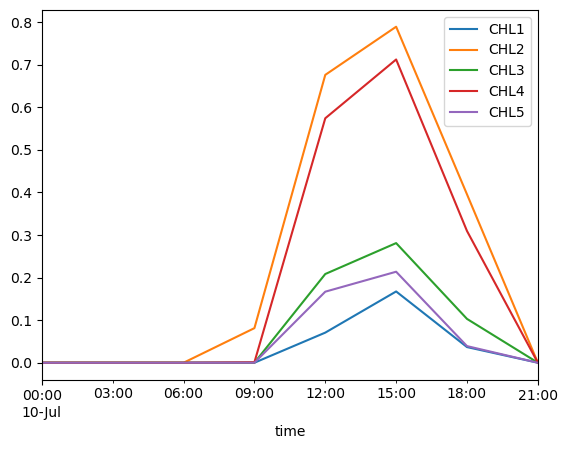

In [119]:
tsSolar.loc["2013-07-10"].plot()

In [120]:
tsSolar = tsSolar[~tsSolar.index.duplicated(keep='first')]

In [121]:
# Adding Solar Power
for region, data in tsSolar.items():
    n.add(
        "Generator",
        f"{region} Solar",
        bus=region,
        carrier="solar",
        p_max_pu=tsSolar[region],
        marginal_cost=costs.at["solar", "VOM"],
        capital_cost=costs.at["solar", "capital_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

#### Check

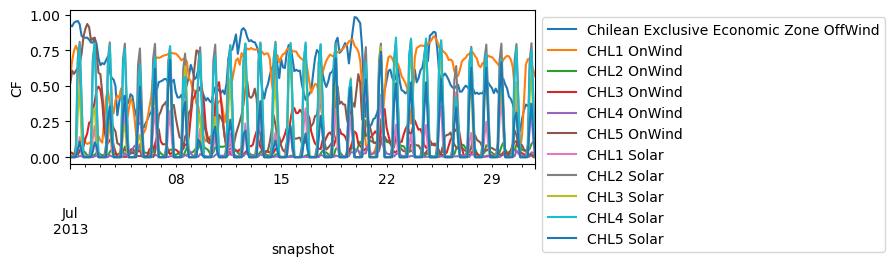

In [122]:
# Assuming n.generators_t.p_max_pu.loc["2013-12"] is your data series
# Plotting the data
ax = n.generators_t.p_max_pu.loc["2013-7"].plot(figsize=(6, 2), ylabel="CF")

# Getting the legend from the plot
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Showing the plot
plt.show()

##### Adding Battery Storage

In [123]:
for index, row in aggregated_regions.iterrows():
    n.add(
        "StorageUnit",
        f"{index} battery storage",
        bus=index,
        carrier="battery storage",
        max_hours=6,
        capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
        efficiency_store=costs.at["battery inverter", "efficiency"],
        efficiency_dispatch=costs.at["battery inverter", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True)

##### Adding Hydorge Storage

In [124]:
# Add an option to build hydrogen storage as StorageUnit with an energy-to-power ratio of 336h.
capital_costs = (
    costs.at["electrolysis", "capital_cost"] +
    costs.at["fuel cell", "capital_cost"] +
    336 * costs.at["hydrogen storage underground", "capital_cost"]
)


for index, row in aggregated_regions.iterrows():
    n.add(
        "StorageUnit",
        f"{index} hydrogen storage underground",
        bus=index,
        carrier="hydrogen storage underground",
        max_hours=336,
        capital_cost=capital_costs,
        efficiency_store=costs.at["electrolysis", "efficiency"],
        efficiency_dispatch=costs.at["fuel cell", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
)

## Investigation 

##### without a limit on CO2 emissions

In [125]:
n.optimize(solver_name="gurobi")

{'Chile EEZ Offshore'}
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-11
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 36.02it/s]
INFO:linopy.io: Writing time: 1.68s


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-js1ui40m.lp


INFO:gurobipy:Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-js1ui40m.lp


Reading time = 0.49 seconds


INFO:gurobipy:Reading time = 0.49 seconds


obj: 420507 rows, 186907 columns, 810777 nonzeros


INFO:gurobipy:obj: 420507 rows, 186907 columns, 810777 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros


INFO:gurobipy:Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros


Model fingerprint: 0x1c543d8f


INFO:gurobipy:Model fingerprint: 0x1c543d8f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-09, 3e+02]


INFO:gurobipy:  Matrix range     [4e-09, 3e+02]


  Objective range  [3e-02, 5e+05]


INFO:gurobipy:  Objective range  [3e-02, 5e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+00, 2e+07]


INFO:gurobipy:  RHS range        [3e+00, 2e+07]


Presolve removed 250422 rows and 60598 columns


INFO:gurobipy:Presolve removed 250422 rows and 60598 columns


Presolve time: 0.33s


INFO:gurobipy:Presolve time: 0.33s


Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 4655


INFO:gurobipy: Free vars  : 4655


 AA' NZ     : 5.498e+05


INFO:gurobipy: AA' NZ     : 5.498e+05


 Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


 Factor Ops : 6.146e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.146e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


INFO:gurobipy:   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


INFO:gurobipy:   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


INFO:gurobipy:   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


INFO:gurobipy:   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


INFO:gurobipy:   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


INFO:gurobipy:   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


INFO:gurobipy:   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


INFO:gurobipy:   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


INFO:gurobipy:   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


INFO:gurobipy:   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


INFO:gurobipy:  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     2s


INFO:gurobipy:  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     2s


  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


INFO:gurobipy:  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


INFO:gurobipy:  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


INFO:gurobipy:  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


INFO:gurobipy:  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


INFO:gurobipy:  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


INFO:gurobipy:  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


INFO:gurobipy:  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


INFO:gurobipy:  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


INFO:gurobipy:  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


INFO:gurobipy:  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     3s


INFO:gurobipy:  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     3s


  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


INFO:gurobipy:  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


INFO:gurobipy:  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


INFO:gurobipy:  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


INFO:gurobipy:  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


  27   1.56169170e+13  1.49314351e+13  2.22e+01 9.83e-01  2.59e+06     3s


INFO:gurobipy:  27   1.56169170e+13  1.49314351e+13  2.22e+01 9.83e-01  2.59e+06     3s


  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


INFO:gurobipy:  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


INFO:gurobipy:  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


INFO:gurobipy:  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


  31   1.55320374e+13  1.51459302e+13  1.24e+01 5.59e-01  1.46e+06     4s


INFO:gurobipy:  31   1.55320374e+13  1.51459302e+13  1.24e+01 5.59e-01  1.46e+06     4s


  32   1.55162560e+13  1.51715297e+13  1.07e+01 5.19e-01  1.30e+06     4s


INFO:gurobipy:  32   1.55162560e+13  1.51715297e+13  1.07e+01 5.19e-01  1.30e+06     4s


  33   1.54908816e+13  1.52280531e+13  7.74e+00 1.13e+00  9.91e+05     4s


INFO:gurobipy:  33   1.54908816e+13  1.52280531e+13  7.74e+00 1.13e+00  9.91e+05     4s


  34   1.54766244e+13  1.52832210e+13  6.06e+00 8.48e-01  7.29e+05     4s


INFO:gurobipy:  34   1.54766244e+13  1.52832210e+13  6.06e+00 8.48e-01  7.29e+05     4s


  35   1.54696764e+13  1.53273266e+13  5.27e+00 6.93e-01  5.37e+05     4s


INFO:gurobipy:  35   1.54696764e+13  1.53273266e+13  5.27e+00 6.93e-01  5.37e+05     4s


  36   1.54662748e+13  1.53397615e+13  4.85e+00 6.77e-01  4.77e+05     4s


INFO:gurobipy:  36   1.54662748e+13  1.53397615e+13  4.85e+00 6.77e-01  4.77e+05     4s


  37   1.54579575e+13  1.53594734e+13  3.90e+00 6.56e-01  3.71e+05     4s


INFO:gurobipy:  37   1.54579575e+13  1.53594734e+13  3.90e+00 6.56e-01  3.71e+05     4s


  38   1.54500375e+13  1.53792208e+13  2.96e+00 5.45e-01  2.67e+05     4s


INFO:gurobipy:  38   1.54500375e+13  1.53792208e+13  2.96e+00 5.45e-01  2.67e+05     4s


  39   1.54459587e+13  1.53848314e+13  2.48e+00 6.11e-01  2.31e+05     4s


INFO:gurobipy:  39   1.54459587e+13  1.53848314e+13  2.48e+00 6.11e-01  2.31e+05     4s


  40   1.54439455e+13  1.53892615e+13  2.24e+00 6.10e-01  2.06e+05     4s


INFO:gurobipy:  40   1.54439455e+13  1.53892615e+13  2.24e+00 6.10e-01  2.06e+05     4s


  41   1.54403943e+13  1.54019367e+13  1.81e+00 5.56e-01  1.45e+05     5s


INFO:gurobipy:  41   1.54403943e+13  1.54019367e+13  1.81e+00 5.56e-01  1.45e+05     5s


  42   1.54373105e+13  1.54068670e+13  1.44e+00 4.76e-01  1.15e+05     5s


INFO:gurobipy:  42   1.54373105e+13  1.54068670e+13  1.44e+00 4.76e-01  1.15e+05     5s


  43   1.54335718e+13  1.54085281e+13  9.72e-01 4.42e-01  9.45e+04     5s


INFO:gurobipy:  43   1.54335718e+13  1.54085281e+13  9.72e-01 4.42e-01  9.45e+04     5s


  44   1.54322704e+13  1.54144281e+13  8.09e-01 4.84e-01  6.74e+04     5s


INFO:gurobipy:  44   1.54322704e+13  1.54144281e+13  8.09e-01 4.84e-01  6.74e+04     5s


  45   1.54318339e+13  1.54164624e+13  7.54e-01 5.25e-01  5.80e+04     5s


INFO:gurobipy:  45   1.54318339e+13  1.54164624e+13  7.54e-01 5.25e-01  5.80e+04     5s


  46   1.54306526e+13  1.54174230e+13  5.92e-01 5.49e-01  5.00e+04     5s


INFO:gurobipy:  46   1.54306526e+13  1.54174230e+13  5.92e-01 5.49e-01  5.00e+04     5s


  47   1.54303460e+13  1.54191085e+13  5.52e-01 5.73e-01  4.25e+04     5s


INFO:gurobipy:  47   1.54303460e+13  1.54191085e+13  5.52e-01 5.73e-01  4.25e+04     5s


  48   1.54294157e+13  1.54201593e+13  4.32e-01 5.27e-01  3.50e+04     5s


INFO:gurobipy:  48   1.54294157e+13  1.54201593e+13  4.32e-01 5.27e-01  3.50e+04     5s


  49   1.54290959e+13  1.54206189e+13  3.88e-01 5.05e-01  3.20e+04     5s


INFO:gurobipy:  49   1.54290959e+13  1.54206189e+13  3.88e-01 5.05e-01  3.20e+04     5s


  50   1.54284882e+13  1.54213925e+13  2.82e-01 4.55e-01  2.68e+04     5s


INFO:gurobipy:  50   1.54284882e+13  1.54213925e+13  2.82e-01 4.55e-01  2.68e+04     5s


  51   1.54281716e+13  1.54224250e+13  2.35e-01 4.21e-01  2.17e+04     6s


INFO:gurobipy:  51   1.54281716e+13  1.54224250e+13  2.35e-01 4.21e-01  2.17e+04     6s


  52   1.54279221e+13  1.54234215e+13  2.02e-01 4.11e-01  1.70e+04     6s


INFO:gurobipy:  52   1.54279221e+13  1.54234215e+13  2.02e-01 4.11e-01  1.70e+04     6s


  53   1.54276717e+13  1.54238830e+13  1.67e-01 3.87e-01  1.43e+04     6s


INFO:gurobipy:  53   1.54276717e+13  1.54238830e+13  1.67e-01 3.87e-01  1.43e+04     6s


  54   1.54275719e+13  1.54240767e+13  1.51e-01 3.68e-01  1.32e+04     6s


INFO:gurobipy:  54   1.54275719e+13  1.54240767e+13  1.51e-01 3.68e-01  1.32e+04     6s


  55   1.54274004e+13  1.54242908e+13  1.24e-01 3.39e-01  1.18e+04     6s


INFO:gurobipy:  55   1.54274004e+13  1.54242908e+13  1.24e-01 3.39e-01  1.18e+04     6s


  56   1.54272262e+13  1.54251603e+13  9.59e-02 3.88e-01  7.83e+03     6s


INFO:gurobipy:  56   1.54272262e+13  1.54251603e+13  9.59e-02 3.88e-01  7.83e+03     6s


  57   1.54271687e+13  1.54252009e+13  8.84e-02 3.93e-01  7.46e+03     6s


INFO:gurobipy:  57   1.54271687e+13  1.54252009e+13  8.84e-02 3.93e-01  7.46e+03     6s


  58   1.54270914e+13  1.54254215e+13  7.68e-02 4.18e-01  6.33e+03     6s


INFO:gurobipy:  58   1.54270914e+13  1.54254215e+13  7.68e-02 4.18e-01  6.33e+03     6s


  59   1.54269352e+13  1.54260024e+13  5.21e-02 2.58e-01  3.54e+03     6s


INFO:gurobipy:  59   1.54269352e+13  1.54260024e+13  5.21e-02 2.58e-01  3.54e+03     6s


  60   1.54268050e+13  1.54261431e+13  3.30e-02 2.65e-01  2.51e+03     6s


INFO:gurobipy:  60   1.54268050e+13  1.54261431e+13  3.30e-02 2.65e-01  2.51e+03     6s


  61   1.54267499e+13  1.54262711e+13  2.49e-02 1.52e-01  1.82e+03     7s


INFO:gurobipy:  61   1.54267499e+13  1.54262711e+13  2.49e-02 1.52e-01  1.82e+03     7s


  62   1.54266722e+13  1.54264036e+13  1.36e-02 1.53e-01  1.02e+03     7s


INFO:gurobipy:  62   1.54266722e+13  1.54264036e+13  1.36e-02 1.53e-01  1.02e+03     7s


  63   1.54266109e+13  1.54264760e+13  6.48e-03 1.53e-01  5.14e+02     7s


INFO:gurobipy:  63   1.54266109e+13  1.54264760e+13  6.48e-03 1.53e-01  5.14e+02     7s


  64   1.54266095e+13  1.54264798e+13  6.30e-03 1.53e-01  4.95e+02     7s


INFO:gurobipy:  64   1.54266095e+13  1.54264798e+13  6.30e-03 1.53e-01  4.95e+02     7s


  65   1.54266031e+13  1.54264829e+13  5.35e-03 1.51e-01  4.59e+02     7s


INFO:gurobipy:  65   1.54266031e+13  1.54264829e+13  5.35e-03 1.51e-01  4.59e+02     7s


  66   1.54266005e+13  1.54265087e+13  4.86e-03 1.13e-01  3.49e+02     7s


INFO:gurobipy:  66   1.54266005e+13  1.54265087e+13  4.86e-03 1.13e-01  3.49e+02     7s


  67   1.54265895e+13  1.54265249e+13  3.36e-03 1.04e-01  2.47e+02     8s


INFO:gurobipy:  67   1.54265895e+13  1.54265249e+13  3.36e-03 1.04e-01  2.47e+02     8s


  68   1.54265748e+13  1.54265527e+13  1.17e-03 3.88e-02  8.45e+01     8s


INFO:gurobipy:  68   1.54265748e+13  1.54265527e+13  1.17e-03 3.88e-02  8.45e+01     8s


  69   1.54265686e+13  1.54265590e+13  3.27e-04 3.88e-02  3.69e+01     8s


INFO:gurobipy:  69   1.54265686e+13  1.54265590e+13  3.27e-04 3.88e-02  3.69e+01     8s


  70   1.54265666e+13  1.54265643e+13  8.78e-05 3.88e-02  9.10e+00     8s


INFO:gurobipy:  70   1.54265666e+13  1.54265643e+13  8.78e-05 3.88e-02  9.10e+00     8s


  71   1.54265663e+13  1.54265646e+13  5.79e-05 3.88e-02  6.90e+00     8s


INFO:gurobipy:  71   1.54265663e+13  1.54265646e+13  5.79e-05 3.88e-02  6.90e+00     8s


  72   1.54265663e+13  1.54265647e+13  5.24e-05 3.88e-02  6.34e+00     8s


INFO:gurobipy:  72   1.54265663e+13  1.54265647e+13  5.24e-05 3.88e-02  6.34e+00     8s


  73   1.54265662e+13  1.54265650e+13  4.37e-05 3.88e-02  5.06e+00     8s


INFO:gurobipy:  73   1.54265662e+13  1.54265650e+13  4.37e-05 3.88e-02  5.06e+00     8s


  74   1.54265661e+13  1.54265654e+13  3.32e-05 3.88e-02  3.02e+00     9s


INFO:gurobipy:  74   1.54265661e+13  1.54265654e+13  3.32e-05 3.88e-02  3.02e+00     9s


  75   1.54265659e+13  1.54265658e+13  1.07e-05 3.88e-02  7.16e-01     9s


INFO:gurobipy:  75   1.54265659e+13  1.54265658e+13  1.07e-05 3.88e-02  7.16e-01     9s


  76   1.54265659e+13  1.54265658e+13  3.07e-04 5.19e-02  7.57e-01     9s


INFO:gurobipy:  76   1.54265659e+13  1.54265658e+13  3.07e-04 5.19e-02  7.57e-01     9s


INFO:gurobipy:


Barrier solved model in 76 iterations and 8.90 seconds (7.20 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 8.90 seconds (7.20 work units)


Optimal objective 1.54265659e+13


INFO:gurobipy:Optimal objective 1.54265659e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   14339 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   14339 DPushes remaining with DInf 0.0000000e+00                 9s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   89534 PPushes remaining with PInf 5.3314447e-02                10s


INFO:gurobipy:   89534 PPushes remaining with PInf 5.3314447e-02                10s


   54335 PPushes remaining with PInf 2.7874623e+00                11s


INFO:gurobipy:   54335 PPushes remaining with PInf 2.7874623e+00                11s


   12185 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:   12185 PPushes remaining with PInf 0.0000000e+00                16s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.0904047e+04     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.0904047e+04     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   96693    1.5426566e+13   0.000000e+00   7.090405e+04     16s


INFO:gurobipy:   96693    1.5426566e+13   0.000000e+00   7.090405e+04     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   97137    1.5426565e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:   97137    1.5426565e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 97137 iterations and 18.02 seconds (21.51 work units)


INFO:gurobipy:Solved in 97137 iterations and 18.02 seconds (21.51 work units)


Optimal objective  1.542656548e+13


INFO:gurobipy:Optimal objective  1.542656548e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 186907 primals, 420507 duals
Objective: 1.54e+13
Solver model: available
Solver message: 2

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

('ok', 'optimal')

In [126]:
n.objective / 1e9

15426.5654764576

##### with a CO2 emission reduction of 100% (no emissions)

In [128]:
sensitivity = {}

# Set CO2 limit to 0
co2_limit = 0
n.global_constraints.loc["CO2Limit", "constant"] = co2_limit * 1e6

n.optimize(solver_name="gurobi")


{'Chile EEZ Offshore'}
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-11
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 38.36it/s]
INFO:linopy.io: Writing time: 1.67s


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-xqh4nxgo.lp


INFO:gurobipy:Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-xqh4nxgo.lp


Reading time = 0.50 seconds


INFO:gurobipy:Reading time = 0.50 seconds


obj: 420507 rows, 186907 columns, 810777 nonzeros


INFO:gurobipy:obj: 420507 rows, 186907 columns, 810777 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros


INFO:gurobipy:Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros


Model fingerprint: 0x1c543d8f


INFO:gurobipy:Model fingerprint: 0x1c543d8f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-09, 3e+02]


INFO:gurobipy:  Matrix range     [4e-09, 3e+02]


  Objective range  [3e-02, 5e+05]


INFO:gurobipy:  Objective range  [3e-02, 5e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+00, 2e+07]


INFO:gurobipy:  RHS range        [3e+00, 2e+07]


Presolve removed 250422 rows and 60598 columns


INFO:gurobipy:Presolve removed 250422 rows and 60598 columns


Presolve time: 0.33s


INFO:gurobipy:Presolve time: 0.33s


Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 4655


INFO:gurobipy: Free vars  : 4655


 AA' NZ     : 5.498e+05


INFO:gurobipy: AA' NZ     : 5.498e+05


 Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


 Factor Ops : 6.146e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.146e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


INFO:gurobipy:   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


INFO:gurobipy:   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


INFO:gurobipy:   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


INFO:gurobipy:   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


INFO:gurobipy:   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


INFO:gurobipy:   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


INFO:gurobipy:   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


INFO:gurobipy:   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


INFO:gurobipy:   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


INFO:gurobipy:   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


INFO:gurobipy:  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     1s


INFO:gurobipy:  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     1s


  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


INFO:gurobipy:  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


INFO:gurobipy:  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


INFO:gurobipy:  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


INFO:gurobipy:  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


INFO:gurobipy:  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


INFO:gurobipy:  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


INFO:gurobipy:  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


INFO:gurobipy:  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


INFO:gurobipy:  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     3s


INFO:gurobipy:  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     3s


  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     3s


INFO:gurobipy:  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     3s


  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


INFO:gurobipy:  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


INFO:gurobipy:  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


INFO:gurobipy:  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


INFO:gurobipy:  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


  27   1.56169170e+13  1.49314351e+13  2.22e+01 9.83e-01  2.59e+06     3s


INFO:gurobipy:  27   1.56169170e+13  1.49314351e+13  2.22e+01 9.83e-01  2.59e+06     3s


  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


INFO:gurobipy:  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


INFO:gurobipy:  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     4s


INFO:gurobipy:  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     4s


  31   1.55320374e+13  1.51459302e+13  1.24e+01 5.59e-01  1.46e+06     4s


INFO:gurobipy:  31   1.55320374e+13  1.51459302e+13  1.24e+01 5.59e-01  1.46e+06     4s


  32   1.55162560e+13  1.51715297e+13  1.07e+01 5.19e-01  1.30e+06     4s


INFO:gurobipy:  32   1.55162560e+13  1.51715297e+13  1.07e+01 5.19e-01  1.30e+06     4s


  33   1.54908816e+13  1.52280531e+13  7.74e+00 1.13e+00  9.91e+05     4s


INFO:gurobipy:  33   1.54908816e+13  1.52280531e+13  7.74e+00 1.13e+00  9.91e+05     4s


  34   1.54766244e+13  1.52832210e+13  6.06e+00 8.48e-01  7.29e+05     4s


INFO:gurobipy:  34   1.54766244e+13  1.52832210e+13  6.06e+00 8.48e-01  7.29e+05     4s


  35   1.54696764e+13  1.53273266e+13  5.27e+00 6.93e-01  5.37e+05     4s


INFO:gurobipy:  35   1.54696764e+13  1.53273266e+13  5.27e+00 6.93e-01  5.37e+05     4s


  36   1.54662748e+13  1.53397615e+13  4.85e+00 6.77e-01  4.77e+05     4s


INFO:gurobipy:  36   1.54662748e+13  1.53397615e+13  4.85e+00 6.77e-01  4.77e+05     4s


  37   1.54579575e+13  1.53594734e+13  3.90e+00 6.56e-01  3.71e+05     4s


INFO:gurobipy:  37   1.54579575e+13  1.53594734e+13  3.90e+00 6.56e-01  3.71e+05     4s


  38   1.54500375e+13  1.53792208e+13  2.96e+00 5.45e-01  2.67e+05     4s


INFO:gurobipy:  38   1.54500375e+13  1.53792208e+13  2.96e+00 5.45e-01  2.67e+05     4s


  39   1.54459587e+13  1.53848314e+13  2.48e+00 6.11e-01  2.31e+05     5s


INFO:gurobipy:  39   1.54459587e+13  1.53848314e+13  2.48e+00 6.11e-01  2.31e+05     5s


  40   1.54439455e+13  1.53892615e+13  2.24e+00 6.10e-01  2.06e+05     5s


INFO:gurobipy:  40   1.54439455e+13  1.53892615e+13  2.24e+00 6.10e-01  2.06e+05     5s


  41   1.54403943e+13  1.54019367e+13  1.81e+00 5.56e-01  1.45e+05     5s


INFO:gurobipy:  41   1.54403943e+13  1.54019367e+13  1.81e+00 5.56e-01  1.45e+05     5s


  42   1.54373105e+13  1.54068670e+13  1.44e+00 4.76e-01  1.15e+05     5s


INFO:gurobipy:  42   1.54373105e+13  1.54068670e+13  1.44e+00 4.76e-01  1.15e+05     5s


  43   1.54335718e+13  1.54085281e+13  9.72e-01 4.42e-01  9.45e+04     5s


INFO:gurobipy:  43   1.54335718e+13  1.54085281e+13  9.72e-01 4.42e-01  9.45e+04     5s


  44   1.54322704e+13  1.54144281e+13  8.09e-01 4.84e-01  6.74e+04     5s


INFO:gurobipy:  44   1.54322704e+13  1.54144281e+13  8.09e-01 4.84e-01  6.74e+04     5s


  45   1.54318339e+13  1.54164624e+13  7.54e-01 5.25e-01  5.80e+04     5s


INFO:gurobipy:  45   1.54318339e+13  1.54164624e+13  7.54e-01 5.25e-01  5.80e+04     5s


  46   1.54306526e+13  1.54174230e+13  5.92e-01 5.49e-01  5.00e+04     5s


INFO:gurobipy:  46   1.54306526e+13  1.54174230e+13  5.92e-01 5.49e-01  5.00e+04     5s


  47   1.54303460e+13  1.54191085e+13  5.52e-01 5.73e-01  4.25e+04     5s


INFO:gurobipy:  47   1.54303460e+13  1.54191085e+13  5.52e-01 5.73e-01  4.25e+04     5s


  48   1.54294157e+13  1.54201593e+13  4.32e-01 5.27e-01  3.50e+04     6s


INFO:gurobipy:  48   1.54294157e+13  1.54201593e+13  4.32e-01 5.27e-01  3.50e+04     6s


  49   1.54290959e+13  1.54206189e+13  3.88e-01 5.05e-01  3.20e+04     6s


INFO:gurobipy:  49   1.54290959e+13  1.54206189e+13  3.88e-01 5.05e-01  3.20e+04     6s


  50   1.54284882e+13  1.54213925e+13  2.82e-01 4.55e-01  2.68e+04     6s


INFO:gurobipy:  50   1.54284882e+13  1.54213925e+13  2.82e-01 4.55e-01  2.68e+04     6s


  51   1.54281716e+13  1.54224250e+13  2.35e-01 4.21e-01  2.17e+04     6s


INFO:gurobipy:  51   1.54281716e+13  1.54224250e+13  2.35e-01 4.21e-01  2.17e+04     6s


  52   1.54279221e+13  1.54234215e+13  2.02e-01 4.11e-01  1.70e+04     6s


INFO:gurobipy:  52   1.54279221e+13  1.54234215e+13  2.02e-01 4.11e-01  1.70e+04     6s


  53   1.54276717e+13  1.54238830e+13  1.67e-01 3.87e-01  1.43e+04     6s


INFO:gurobipy:  53   1.54276717e+13  1.54238830e+13  1.67e-01 3.87e-01  1.43e+04     6s


  54   1.54275719e+13  1.54240767e+13  1.51e-01 3.68e-01  1.32e+04     6s


INFO:gurobipy:  54   1.54275719e+13  1.54240767e+13  1.51e-01 3.68e-01  1.32e+04     6s


  55   1.54274004e+13  1.54242908e+13  1.24e-01 3.39e-01  1.18e+04     6s


INFO:gurobipy:  55   1.54274004e+13  1.54242908e+13  1.24e-01 3.39e-01  1.18e+04     6s


  56   1.54272262e+13  1.54251603e+13  9.59e-02 3.88e-01  7.83e+03     6s


INFO:gurobipy:  56   1.54272262e+13  1.54251603e+13  9.59e-02 3.88e-01  7.83e+03     6s


  57   1.54271687e+13  1.54252009e+13  8.84e-02 3.93e-01  7.46e+03     7s


INFO:gurobipy:  57   1.54271687e+13  1.54252009e+13  8.84e-02 3.93e-01  7.46e+03     7s


  58   1.54270914e+13  1.54254215e+13  7.68e-02 4.18e-01  6.33e+03     7s


INFO:gurobipy:  58   1.54270914e+13  1.54254215e+13  7.68e-02 4.18e-01  6.33e+03     7s


  59   1.54269352e+13  1.54260024e+13  5.21e-02 2.58e-01  3.54e+03     7s


INFO:gurobipy:  59   1.54269352e+13  1.54260024e+13  5.21e-02 2.58e-01  3.54e+03     7s


  60   1.54268050e+13  1.54261431e+13  3.30e-02 2.65e-01  2.51e+03     7s


INFO:gurobipy:  60   1.54268050e+13  1.54261431e+13  3.30e-02 2.65e-01  2.51e+03     7s


  61   1.54267499e+13  1.54262711e+13  2.49e-02 1.52e-01  1.82e+03     7s


INFO:gurobipy:  61   1.54267499e+13  1.54262711e+13  2.49e-02 1.52e-01  1.82e+03     7s


  62   1.54266722e+13  1.54264036e+13  1.36e-02 1.53e-01  1.02e+03     7s


INFO:gurobipy:  62   1.54266722e+13  1.54264036e+13  1.36e-02 1.53e-01  1.02e+03     7s


  63   1.54266109e+13  1.54264760e+13  6.48e-03 1.53e-01  5.14e+02     7s


INFO:gurobipy:  63   1.54266109e+13  1.54264760e+13  6.48e-03 1.53e-01  5.14e+02     7s


  64   1.54266095e+13  1.54264798e+13  6.30e-03 1.53e-01  4.95e+02     8s


INFO:gurobipy:  64   1.54266095e+13  1.54264798e+13  6.30e-03 1.53e-01  4.95e+02     8s


  65   1.54266031e+13  1.54264829e+13  5.35e-03 1.51e-01  4.59e+02     8s


INFO:gurobipy:  65   1.54266031e+13  1.54264829e+13  5.35e-03 1.51e-01  4.59e+02     8s


  66   1.54266005e+13  1.54265087e+13  4.86e-03 1.13e-01  3.49e+02     8s


INFO:gurobipy:  66   1.54266005e+13  1.54265087e+13  4.86e-03 1.13e-01  3.49e+02     8s


  67   1.54265895e+13  1.54265249e+13  3.36e-03 1.04e-01  2.47e+02     8s


INFO:gurobipy:  67   1.54265895e+13  1.54265249e+13  3.36e-03 1.04e-01  2.47e+02     8s


  68   1.54265748e+13  1.54265527e+13  1.17e-03 3.88e-02  8.45e+01     8s


INFO:gurobipy:  68   1.54265748e+13  1.54265527e+13  1.17e-03 3.88e-02  8.45e+01     8s


  69   1.54265686e+13  1.54265590e+13  3.27e-04 3.88e-02  3.69e+01     8s


INFO:gurobipy:  69   1.54265686e+13  1.54265590e+13  3.27e-04 3.88e-02  3.69e+01     8s


  70   1.54265666e+13  1.54265643e+13  8.78e-05 3.88e-02  9.10e+00     9s


INFO:gurobipy:  70   1.54265666e+13  1.54265643e+13  8.78e-05 3.88e-02  9.10e+00     9s


  71   1.54265663e+13  1.54265646e+13  5.79e-05 3.88e-02  6.90e+00     9s


INFO:gurobipy:  71   1.54265663e+13  1.54265646e+13  5.79e-05 3.88e-02  6.90e+00     9s


  72   1.54265663e+13  1.54265647e+13  5.24e-05 3.88e-02  6.34e+00     9s


INFO:gurobipy:  72   1.54265663e+13  1.54265647e+13  5.24e-05 3.88e-02  6.34e+00     9s


  73   1.54265662e+13  1.54265650e+13  4.37e-05 3.88e-02  5.06e+00     9s


INFO:gurobipy:  73   1.54265662e+13  1.54265650e+13  4.37e-05 3.88e-02  5.06e+00     9s


  74   1.54265661e+13  1.54265654e+13  3.32e-05 3.88e-02  3.02e+00     9s


INFO:gurobipy:  74   1.54265661e+13  1.54265654e+13  3.32e-05 3.88e-02  3.02e+00     9s


  75   1.54265659e+13  1.54265658e+13  1.07e-05 3.88e-02  7.16e-01     9s


INFO:gurobipy:  75   1.54265659e+13  1.54265658e+13  1.07e-05 3.88e-02  7.16e-01     9s


  76   1.54265659e+13  1.54265658e+13  3.07e-04 5.19e-02  7.57e-01    10s


INFO:gurobipy:  76   1.54265659e+13  1.54265658e+13  3.07e-04 5.19e-02  7.57e-01    10s


INFO:gurobipy:


Barrier solved model in 76 iterations and 9.56 seconds (7.20 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 9.56 seconds (7.20 work units)


Optimal objective 1.54265659e+13


INFO:gurobipy:Optimal objective 1.54265659e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   14339 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   14339 DPushes remaining with DInf 0.0000000e+00                10s


     692 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:     692 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   89534 PPushes remaining with PInf 5.3314447e-02                10s


INFO:gurobipy:   89534 PPushes remaining with PInf 5.3314447e-02                10s


   12185 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:   12185 PPushes remaining with PInf 0.0000000e+00                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.0904047e+04     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.0904047e+04     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   96693    1.5426566e+13   0.000000e+00   7.090405e+04     17s


INFO:gurobipy:   96693    1.5426566e+13   0.000000e+00   7.090405e+04     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   97137    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:   97137    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 97137 iterations and 18.51 seconds (21.51 work units)


INFO:gurobipy:Solved in 97137 iterations and 18.51 seconds (21.51 work units)


Optimal objective  1.542656548e+13


INFO:gurobipy:Optimal objective  1.542656548e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 186907 primals, 420507 duals
Objective: 1.54e+13
Solver model: available
Solver message: 2

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

('ok', 'optimal')

In [129]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

In [131]:

# System cost in the sensitivity limit co2 = 0
sensitivity[co2_limit] = system_cost(n)
sensitivity[co2_limit] 

carrier
Biomass                         0.000000e+00
Coal                            0.000000e+00
Gas                             0.000000e+00
Hydro                           0.000000e+00
Oil                             0.000000e+00
Petcoke                         0.000000e+00
offwind                         0.000000e+00
onwind                          2.125039e+06
solar                           6.918677e+06
HVAC                            6.154347e+05
battery storage                 3.307934e+06
hydrogen storage underground    2.459482e+06
dtype: float64

##### Sensitivity analysis: Variations of battery costs

In [137]:
sensitivity_battery = {}

for battery_storage_cost in [0, 20, 40, 60, 80, 100]: # %
    for index, row in aggregated_regions.iterrows():
        bus=index
        n.storage_units.loc[f"{bus} battery storage", 'capital_cost'] = (battery_storage_cost/100) * costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"]
    n.optimize(solver_name='gurobi')
    sensitivity_battery[battery_storage_cost] = system_cost(n)
sensitivity_battery

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-11


Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 38.59it/s]


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-ejw7bqxw.lp
Reading time = 0.48 seconds
obj: 420507 rows, 186907 columns, 810777 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros
Model fingerprint: 0xed0edb81
Coefficient statistics:
  Matrix range     [4e-09, 3e+02]
  Objective range  [3e-02, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+07]
Presolve removed 250422 rows and 60598 columns
Presolve time: 0.35s
Presolved: 170085 rows, 126309 columns, 557980 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.07s

Barrier statistics:
 Dense cols : 24
 Free vars  : 4655
 AA' NZ     : 5.498e+05
 F

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:473: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` with

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-11


Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 38.11it/s]


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-94b6745w.lp
Reading time = 0.48 seconds
obj: 420507 rows, 186907 columns, 810777 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros
Model fingerprint: 0x7d10e61e
Coefficient statistics:
  Matrix range     [4e-09, 3e+02]
  Objective range  [3e-02, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+07]
Presolve removed 250422 rows and 60598 columns
Presolve time: 0.32s
Presolved: 170085 rows, 126309 columns, 557980 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.06s

Barrier statistics:
 Dense cols : 24
 Free vars  : 4655
 AA' NZ     : 5.498e+05
 F

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:473: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` with

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-11


Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 39.14it/s]


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-a_qruge7.lp
Reading time = 0.49 seconds
obj: 420507 rows, 186907 columns, 810777 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros
Model fingerprint: 0xffc9dc91
Coefficient statistics:
  Matrix range     [4e-09, 3e+02]
  Objective range  [3e-02, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+07]
Presolve removed 250422 rows and 60598 columns
Presolve time: 0.33s
Presolved: 170085 rows, 126309 columns, 557980 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.06s

Barrier statistics:
 Dense cols : 24
 Free vars  : 4655
 AA' NZ     : 5.498e+05
 F

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:473: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` with

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-11


Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 33.74it/s]


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-uhn6syg7.lp
Reading time = 0.46 seconds
obj: 420507 rows, 186907 columns, 810777 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros
Model fingerprint: 0xe1ae3b6e
Coefficient statistics:
  Matrix range     [4e-09, 3e+02]
  Objective range  [3e-02, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+07]
Presolve removed 250422 rows and 60598 columns
Presolve time: 0.32s
Presolved: 170085 rows, 126309 columns, 557980 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.07s

Barrier statistics:
 Dense cols : 24
 Free vars  : 4655
 AA' NZ     : 5.498e+05
 F

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:473: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` with

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-11


Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 38.72it/s]


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-1cvqko2b.lp
Reading time = 0.50 seconds
obj: 420507 rows, 186907 columns, 810777 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros
Model fingerprint: 0xa089371d
Coefficient statistics:
  Matrix range     [4e-09, 3e+02]
  Objective range  [3e-02, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+07]
Presolve removed 250422 rows and 60598 columns
Presolve time: 0.33s
Presolved: 170085 rows, 126309 columns, 557980 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics:
 Dense cols : 24
 Free vars  : 4655
 AA' NZ     : 5.498e+05
 F

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:473: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` with

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-11


Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 35.96it/s]


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-gnfpyath.lp
Reading time = 0.50 seconds
obj: 420507 rows, 186907 columns, 810777 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 420507 rows, 186907 columns and 810777 nonzeros
Model fingerprint: 0x1c543d8f
Coefficient statistics:
  Matrix range     [4e-09, 3e+02]
  Objective range  [3e-02, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+07]
Presolve removed 250422 rows and 60598 columns
Presolve time: 0.30s
Presolved: 170085 rows, 126309 columns, 557980 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.08s

Barrier statistics:
 Dense cols : 24
 Free vars  : 4655
 AA' NZ     : 5.498e+05
 F

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:473: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



{0: carrier
 Biomass                         0.000000e+00
 Coal                            0.000000e+00
 Gas                             0.000000e+00
 Hydro                           0.000000e+00
 Oil                             0.000000e+00
 Petcoke                         0.000000e+00
 offwind                         0.000000e+00
 onwind                          1.411010e+06
 solar                           7.101398e+06
 HVAC                            5.895970e+05
 battery storage                 2.773456e+06
 hydrogen storage underground    2.873910e+06
 dtype: float64,
 20: carrier
 Biomass                         0.000000e+00
 Coal                            0.000000e+00
 Gas                             0.000000e+00
 Hydro                           0.000000e+00
 Oil                             0.000000e+00
 Petcoke                         0.000000e+00
 offwind                         0.000000e+00
 onwind                          1.410571e+06
 solar                           7.103

In [139]:
sensitivity_battery = pd.DataFrame(sensitivity_battery ) # million €/a
sensitivity_battery 

,0,20,40,60,80,100
carrier,,,,,,
Biomass,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Coal,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Gas,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Hydro,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Oil,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Petcoke,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
offwind,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
onwind,1.411010e+06,1.410571e+06,1.620805e+06,2.094136e+06,2.124376e+06,2.125039e+06
solar,7.101398e+06,7.103749e+06,7.046762e+06,6.905351e+06,6.913359e+06,6.918677e+06


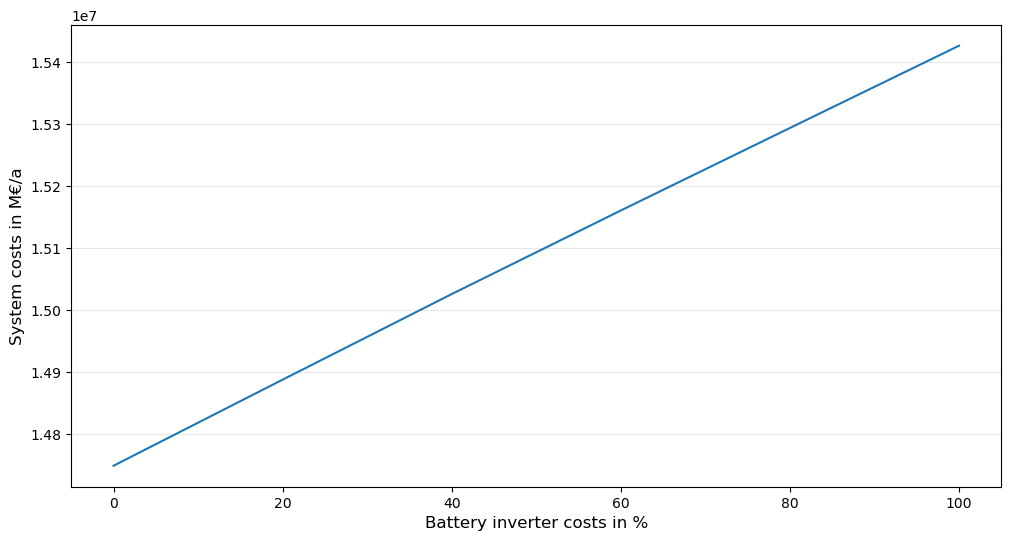

In [140]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel('Battery inverter costs in %', fontsize = 12)
plt.ylabel('System costs in M€/a', fontsize = 12)
plt.grid(alpha=0.3, axis = 'y', linewidth = 0.7)
plt.plot(sensitivity_battery.sum())

In [146]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

In [147]:
system_cost(n)

carrier
battery storage                 3.307934e+06
hydrogen storage underground    2.459482e+06
HVAC                            6.154347e+05
Biomass                         0.000000e+00
Coal                            0.000000e+00
Gas                             0.000000e+00
Hydro                           0.000000e+00
Oil                             0.000000e+00
Petcoke                         0.000000e+00
offwind                         0.000000e+00
onwind                          2.125039e+06
solar                           6.918677e+06
dtype: float64

##### sensitivity analysis with a CO2 emission reduction

In [148]:
sensitivity = {}
for co2 in [150, 100, 50, 25, 0]:
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.optimize(solver_name="gurobi")
    sensitivity[co2] = system_cost(n)

Index(['Chile EEZ Offshore - Central Chile incl. Santiago', 'Chilean Exclusive Economic Zone-Southern Chile'], dtype='object', name='Link')
{'Chile EEZ Offshore'}
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['2013-12-31 21:00:00'], dtype='datetime64[ns]', name='snapshot', freq='3h')
DatetimeIndex(['20

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-11
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 36.34it/s]
INFO:linopy.io: Writing time: 1.68s


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-yri6r7e2.lp


INFO:gurobipy:Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-yri6r7e2.lp


Reading time = 0.48 seconds


INFO:gurobipy:Reading time = 0.48 seconds


obj: 432189 rows, 192749 columns, 834139 nonzeros


INFO:gurobipy:obj: 432189 rows, 192749 columns, 834139 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


INFO:gurobipy:Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


Model fingerprint: 0x27380021


INFO:gurobipy:Model fingerprint: 0x27380021


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-09, 3e+02]


INFO:gurobipy:  Matrix range     [4e-09, 3e+02]


  Objective range  [3e-02, 5e+05]


INFO:gurobipy:  Objective range  [3e-02, 5e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+00, 2e+07]


INFO:gurobipy:  RHS range        [3e+00, 2e+07]


Presolve removed 262104 rows and 66440 columns


INFO:gurobipy:Presolve removed 262104 rows and 66440 columns


Presolve time: 0.30s


INFO:gurobipy:Presolve time: 0.30s


Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 4655


INFO:gurobipy: Free vars  : 4655


 AA' NZ     : 5.498e+05


INFO:gurobipy: AA' NZ     : 5.498e+05


 Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


 Factor Ops : 6.146e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.146e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


INFO:gurobipy:   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


INFO:gurobipy:   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


INFO:gurobipy:   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


INFO:gurobipy:   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


INFO:gurobipy:   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


INFO:gurobipy:   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


INFO:gurobipy:   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


INFO:gurobipy:   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


INFO:gurobipy:   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


INFO:gurobipy:   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


INFO:gurobipy:  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     2s


INFO:gurobipy:  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     2s


  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


INFO:gurobipy:  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


INFO:gurobipy:  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


INFO:gurobipy:  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


INFO:gurobipy:  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


INFO:gurobipy:  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


INFO:gurobipy:  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


INFO:gurobipy:  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


INFO:gurobipy:  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


INFO:gurobipy:  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


INFO:gurobipy:  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     3s


INFO:gurobipy:  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     3s


  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


INFO:gurobipy:  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


INFO:gurobipy:  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


INFO:gurobipy:  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


INFO:gurobipy:  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


INFO:gurobipy:  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


INFO:gurobipy:  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


INFO:gurobipy:  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


INFO:gurobipy:  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     3s


INFO:gurobipy:  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     3s


  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     4s


INFO:gurobipy:  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     4s


  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     4s


INFO:gurobipy:  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     4s


  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


INFO:gurobipy:  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


INFO:gurobipy:  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


INFO:gurobipy:  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


INFO:gurobipy:  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     4s


INFO:gurobipy:  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     4s


  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     4s


INFO:gurobipy:  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     4s


  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     4s


INFO:gurobipy:  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     4s


  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     5s


INFO:gurobipy:  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     5s


  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     5s


INFO:gurobipy:  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     5s


  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     5s


INFO:gurobipy:  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     5s


  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


INFO:gurobipy:  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


INFO:gurobipy:  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     5s


INFO:gurobipy:  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     5s


  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     5s


INFO:gurobipy:  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     5s


  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     5s


INFO:gurobipy:  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     5s


  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     5s


INFO:gurobipy:  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     5s


  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     6s


INFO:gurobipy:  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     6s


  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     6s


INFO:gurobipy:  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     6s


  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     6s


INFO:gurobipy:  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     6s


  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     6s


INFO:gurobipy:  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     6s


  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


INFO:gurobipy:  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     6s


INFO:gurobipy:  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     6s


  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     6s


INFO:gurobipy:  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     6s


  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     6s


INFO:gurobipy:  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     6s


  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     6s


INFO:gurobipy:  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     6s


  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     6s


INFO:gurobipy:  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     6s


  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     7s


INFO:gurobipy:  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     7s


  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     7s


INFO:gurobipy:  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     7s


  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     7s


INFO:gurobipy:  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     7s


  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


INFO:gurobipy:  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     7s


INFO:gurobipy:  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     7s


  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     7s


INFO:gurobipy:  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     7s


  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     7s


INFO:gurobipy:  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     7s


  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     8s


INFO:gurobipy:  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     8s


  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     8s


INFO:gurobipy:  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     8s


  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     8s


INFO:gurobipy:  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     8s


  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     8s


INFO:gurobipy:  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     8s


  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     8s


INFO:gurobipy:  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     8s


  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     8s


INFO:gurobipy:  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     8s


  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     8s


INFO:gurobipy:  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     8s


  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     8s


INFO:gurobipy:  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     8s


  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     9s


INFO:gurobipy:  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     9s


  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     9s


INFO:gurobipy:  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     9s


INFO:gurobipy:


Barrier solved model in 76 iterations and 8.65 seconds (6.79 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 8.65 seconds (6.79 work units)


Optimal objective 1.54265658e+13


INFO:gurobipy:Optimal objective 1.54265658e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8006 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:    8006 DPushes remaining with DInf 0.0000000e+00                 9s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   89304 PPushes remaining with PInf 4.6803534e-02                 9s


INFO:gurobipy:   89304 PPushes remaining with PInf 4.6803534e-02                 9s


   46759 PPushes remaining with PInf 6.6065558e-02                14s


INFO:gurobipy:   46759 PPushes remaining with PInf 6.6065558e-02                14s


   12863 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:   12863 PPushes remaining with PInf 0.0000000e+00                16s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   92252    1.5426565e+13   0.000000e+00   5.834627e+03     18s


INFO:gurobipy:   92252    1.5426565e+13   0.000000e+00   5.834627e+03     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   92344    1.5426565e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:   92344    1.5426565e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 92344 iterations and 18.20 seconds (22.12 work units)


INFO:gurobipy:Solved in 92344 iterations and 18.20 seconds (22.12 work units)


Optimal objective  1.542656548e+13


INFO:gurobipy:Optimal objective  1.542656548e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 192749 primals, 432189 duals
Objective: 1.54e+13
Solver model: available
Solver message: 2

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-11
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 35.72it/s]
INFO:linopy.io: Writing time: 1.68s


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-nn2t3tws.lp


INFO:gurobipy:Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-nn2t3tws.lp


Reading time = 0.50 seconds


INFO:gurobipy:Reading time = 0.50 seconds


obj: 432189 rows, 192749 columns, 834139 nonzeros


INFO:gurobipy:obj: 432189 rows, 192749 columns, 834139 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


INFO:gurobipy:Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


Model fingerprint: 0x27380021


INFO:gurobipy:Model fingerprint: 0x27380021


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-09, 3e+02]


INFO:gurobipy:  Matrix range     [4e-09, 3e+02]


  Objective range  [3e-02, 5e+05]


INFO:gurobipy:  Objective range  [3e-02, 5e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+00, 2e+07]


INFO:gurobipy:  RHS range        [3e+00, 2e+07]


Presolve removed 262104 rows and 66440 columns


INFO:gurobipy:Presolve removed 262104 rows and 66440 columns


Presolve time: 0.34s


INFO:gurobipy:Presolve time: 0.34s


Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 4655


INFO:gurobipy: Free vars  : 4655


 AA' NZ     : 5.498e+05


INFO:gurobipy: AA' NZ     : 5.498e+05


 Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


 Factor Ops : 6.146e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.146e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


INFO:gurobipy:   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


INFO:gurobipy:   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


INFO:gurobipy:   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


INFO:gurobipy:   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


INFO:gurobipy:   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


INFO:gurobipy:   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


INFO:gurobipy:   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


INFO:gurobipy:   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


INFO:gurobipy:   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


INFO:gurobipy:   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     2s


INFO:gurobipy:  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     2s


  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     2s


INFO:gurobipy:  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     2s


  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


INFO:gurobipy:  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


INFO:gurobipy:  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


INFO:gurobipy:  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


INFO:gurobipy:  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


INFO:gurobipy:  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


INFO:gurobipy:  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


INFO:gurobipy:  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     3s


INFO:gurobipy:  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     3s


  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     3s


INFO:gurobipy:  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     3s


  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     3s


INFO:gurobipy:  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     3s


  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     3s


INFO:gurobipy:  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     3s


  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


INFO:gurobipy:  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


INFO:gurobipy:  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


INFO:gurobipy:  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


INFO:gurobipy:  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


INFO:gurobipy:  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     4s


INFO:gurobipy:  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     4s


  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     4s


INFO:gurobipy:  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     4s


  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     4s


INFO:gurobipy:  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     4s


  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     4s


INFO:gurobipy:  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     4s


  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     4s


INFO:gurobipy:  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     4s


  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     4s


INFO:gurobipy:  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     4s


  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


INFO:gurobipy:  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


INFO:gurobipy:  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


INFO:gurobipy:  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


INFO:gurobipy:  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     5s


INFO:gurobipy:  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     5s


  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     5s


INFO:gurobipy:  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     5s


  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     5s


INFO:gurobipy:  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     5s


  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     5s


INFO:gurobipy:  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     5s


  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     5s


INFO:gurobipy:  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     5s


  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     5s


INFO:gurobipy:  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     5s


  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


INFO:gurobipy:  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


INFO:gurobipy:  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     6s


INFO:gurobipy:  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     6s


  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     6s


INFO:gurobipy:  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     6s


  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     6s


INFO:gurobipy:  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     6s


  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     6s


INFO:gurobipy:  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     6s


  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     6s


INFO:gurobipy:  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     6s


  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     6s


INFO:gurobipy:  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     6s


  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     6s


INFO:gurobipy:  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     6s


  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     6s


INFO:gurobipy:  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     6s


  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


INFO:gurobipy:  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     7s


INFO:gurobipy:  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     7s


  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     7s


INFO:gurobipy:  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     7s


  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     7s


INFO:gurobipy:  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     7s


  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     7s


INFO:gurobipy:  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     7s


  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     7s


INFO:gurobipy:  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     7s


  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     7s


INFO:gurobipy:  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     7s


  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     7s


INFO:gurobipy:  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     7s


  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     7s


INFO:gurobipy:  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     7s


  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


INFO:gurobipy:  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     8s


INFO:gurobipy:  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     8s


  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     8s


INFO:gurobipy:  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     8s


  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     8s


INFO:gurobipy:  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     8s


  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     8s


INFO:gurobipy:  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     8s


  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     8s


INFO:gurobipy:  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     8s


  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     9s


INFO:gurobipy:  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     9s


  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     9s


INFO:gurobipy:  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     9s


  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     9s


INFO:gurobipy:  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     9s


  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     9s


INFO:gurobipy:  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     9s


  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     9s


INFO:gurobipy:  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     9s


  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     9s


INFO:gurobipy:  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     9s


  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     9s


INFO:gurobipy:  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     9s


  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     9s


INFO:gurobipy:  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     9s


INFO:gurobipy:


Barrier solved model in 76 iterations and 9.32 seconds (6.79 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 9.32 seconds (6.79 work units)


Optimal objective 1.54265658e+13


INFO:gurobipy:Optimal objective 1.54265658e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8006 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:    8006 DPushes remaining with DInf 0.0000000e+00                 9s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   89304 PPushes remaining with PInf 4.6803534e-02                10s


INFO:gurobipy:   89304 PPushes remaining with PInf 4.6803534e-02                10s


   46759 PPushes remaining with PInf 6.6065558e-02                14s


INFO:gurobipy:   46759 PPushes remaining with PInf 6.6065558e-02                14s


   22966 PPushes remaining with PInf 2.4723895e-02                15s


INFO:gurobipy:   22966 PPushes remaining with PInf 2.4723895e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     19s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   92252    1.5426565e+13   0.000000e+00   5.834627e+03     19s


INFO:gurobipy:   92252    1.5426565e+13   0.000000e+00   5.834627e+03     19s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   92344    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:   92344    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 92344 iterations and 18.95 seconds (22.12 work units)


INFO:gurobipy:Solved in 92344 iterations and 18.95 seconds (22.12 work units)


Optimal objective  1.542656548e+13


INFO:gurobipy:Optimal objective  1.542656548e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 192749 primals, 432189 duals
Objective: 1.54e+13
Solver model: available
Solver message: 2

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-11
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 37.59it/s]
INFO:linopy.io: Writing time: 1.7s


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-lhgc5h_d.lp


INFO:gurobipy:Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-lhgc5h_d.lp


Reading time = 0.50 seconds


INFO:gurobipy:Reading time = 0.50 seconds


obj: 432189 rows, 192749 columns, 834139 nonzeros


INFO:gurobipy:obj: 432189 rows, 192749 columns, 834139 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


INFO:gurobipy:Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


Model fingerprint: 0x27380021


INFO:gurobipy:Model fingerprint: 0x27380021


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-09, 3e+02]


INFO:gurobipy:  Matrix range     [4e-09, 3e+02]


  Objective range  [3e-02, 5e+05]


INFO:gurobipy:  Objective range  [3e-02, 5e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+00, 2e+07]


INFO:gurobipy:  RHS range        [3e+00, 2e+07]


Presolve removed 262104 rows and 66440 columns


INFO:gurobipy:Presolve removed 262104 rows and 66440 columns


Presolve time: 0.32s


INFO:gurobipy:Presolve time: 0.32s


Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 4655


INFO:gurobipy: Free vars  : 4655


 AA' NZ     : 5.498e+05


INFO:gurobipy: AA' NZ     : 5.498e+05


 Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


 Factor Ops : 6.146e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.146e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


INFO:gurobipy:   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


INFO:gurobipy:   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


INFO:gurobipy:   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


INFO:gurobipy:   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


INFO:gurobipy:   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


INFO:gurobipy:   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


INFO:gurobipy:   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


INFO:gurobipy:   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


INFO:gurobipy:   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


INFO:gurobipy:   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


INFO:gurobipy:  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     1s


INFO:gurobipy:  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     1s


  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


INFO:gurobipy:  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     2s


  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


INFO:gurobipy:  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     2s


  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


INFO:gurobipy:  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


INFO:gurobipy:  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


INFO:gurobipy:  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


INFO:gurobipy:  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


INFO:gurobipy:  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


INFO:gurobipy:  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


INFO:gurobipy:  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


INFO:gurobipy:  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     2s


INFO:gurobipy:  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     2s


  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


INFO:gurobipy:  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


INFO:gurobipy:  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


INFO:gurobipy:  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


INFO:gurobipy:  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


INFO:gurobipy:  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


INFO:gurobipy:  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


INFO:gurobipy:  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


INFO:gurobipy:  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     3s


INFO:gurobipy:  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     3s


  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     3s


INFO:gurobipy:  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     3s


  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     4s


INFO:gurobipy:  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     4s


  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


INFO:gurobipy:  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


INFO:gurobipy:  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


INFO:gurobipy:  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


INFO:gurobipy:  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     4s


INFO:gurobipy:  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     4s


  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     4s


INFO:gurobipy:  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     4s


  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     4s


INFO:gurobipy:  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     4s


  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     4s


INFO:gurobipy:  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     4s


  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     4s


INFO:gurobipy:  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     4s


  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     4s


INFO:gurobipy:  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     4s


  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


INFO:gurobipy:  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


INFO:gurobipy:  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     5s


INFO:gurobipy:  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     5s


  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     5s


INFO:gurobipy:  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     5s


  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     5s


INFO:gurobipy:  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     5s


  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     5s


INFO:gurobipy:  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     5s


  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     5s


INFO:gurobipy:  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     5s


  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     5s


INFO:gurobipy:  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     5s


  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     5s


INFO:gurobipy:  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     5s


  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     5s


INFO:gurobipy:  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     5s


  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


INFO:gurobipy:  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     6s


INFO:gurobipy:  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     6s


  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     6s


INFO:gurobipy:  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     6s


  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     6s


INFO:gurobipy:  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     6s


  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     6s


INFO:gurobipy:  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     6s


  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     6s


INFO:gurobipy:  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     6s


  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     6s


INFO:gurobipy:  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     6s


  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     6s


INFO:gurobipy:  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     6s


  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     6s


INFO:gurobipy:  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     6s


  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


INFO:gurobipy:  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     7s


INFO:gurobipy:  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     7s


  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     7s


INFO:gurobipy:  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     7s


  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     7s


INFO:gurobipy:  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     7s


  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     7s


INFO:gurobipy:  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     7s


  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     7s


INFO:gurobipy:  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     7s


  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     8s


INFO:gurobipy:  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     8s


  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     8s


INFO:gurobipy:  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     8s


  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     8s


INFO:gurobipy:  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     8s


  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     8s


INFO:gurobipy:  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     8s


  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     8s


INFO:gurobipy:  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     8s


  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     8s


INFO:gurobipy:  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     8s


  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     8s


INFO:gurobipy:  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     8s


  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     8s


INFO:gurobipy:  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     8s


INFO:gurobipy:


Barrier solved model in 76 iterations and 8.25 seconds (6.79 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 8.25 seconds (6.79 work units)


Optimal objective 1.54265658e+13


INFO:gurobipy:Optimal objective 1.54265658e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8006 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:    8006 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   89304 PPushes remaining with PInf 4.6803534e-02                 9s


INFO:gurobipy:   89304 PPushes remaining with PInf 4.6803534e-02                 9s


   46759 PPushes remaining with PInf 6.6065558e-02                14s


INFO:gurobipy:   46759 PPushes remaining with PInf 6.6065558e-02                14s


   12863 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:   12863 PPushes remaining with PInf 0.0000000e+00                16s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   92252    1.5426565e+13   0.000000e+00   5.834627e+03     18s


INFO:gurobipy:   92252    1.5426565e+13   0.000000e+00   5.834627e+03     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   92344    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:   92344    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 92344 iterations and 18.51 seconds (22.12 work units)


INFO:gurobipy:Solved in 92344 iterations and 18.51 seconds (22.12 work units)


Optimal objective  1.542656548e+13


INFO:gurobipy:Optimal objective  1.542656548e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 192749 primals, 432189 duals
Objective: 1.54e+13
Solver model: available
Solver message: 2

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-11
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 35.81it/s]
INFO:linopy.io: Writing time: 1.65s


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-imn1kdvi.lp


INFO:gurobipy:Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-imn1kdvi.lp


Reading time = 0.50 seconds


INFO:gurobipy:Reading time = 0.50 seconds


obj: 432189 rows, 192749 columns, 834139 nonzeros


INFO:gurobipy:obj: 432189 rows, 192749 columns, 834139 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


INFO:gurobipy:Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


Model fingerprint: 0x27380021


INFO:gurobipy:Model fingerprint: 0x27380021


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-09, 3e+02]


INFO:gurobipy:  Matrix range     [4e-09, 3e+02]


  Objective range  [3e-02, 5e+05]


INFO:gurobipy:  Objective range  [3e-02, 5e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+00, 2e+07]


INFO:gurobipy:  RHS range        [3e+00, 2e+07]


Presolve removed 262104 rows and 66440 columns


INFO:gurobipy:Presolve removed 262104 rows and 66440 columns


Presolve time: 0.30s


INFO:gurobipy:Presolve time: 0.30s


Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 4655


INFO:gurobipy: Free vars  : 4655


 AA' NZ     : 5.498e+05


INFO:gurobipy: AA' NZ     : 5.498e+05


 Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


 Factor Ops : 6.146e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.146e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


INFO:gurobipy:   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


INFO:gurobipy:   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


INFO:gurobipy:   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


INFO:gurobipy:   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


INFO:gurobipy:   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


INFO:gurobipy:   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


INFO:gurobipy:   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


INFO:gurobipy:   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


INFO:gurobipy:   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


INFO:gurobipy:   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


INFO:gurobipy:  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     1s


INFO:gurobipy:  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     1s


  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     1s


INFO:gurobipy:  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     1s


  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     1s


INFO:gurobipy:  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     1s


  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


INFO:gurobipy:  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


INFO:gurobipy:  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


INFO:gurobipy:  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


INFO:gurobipy:  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


INFO:gurobipy:  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


INFO:gurobipy:  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


INFO:gurobipy:  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


INFO:gurobipy:  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     2s


INFO:gurobipy:  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     2s


  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     2s


INFO:gurobipy:  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     2s


  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


INFO:gurobipy:  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


INFO:gurobipy:  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


INFO:gurobipy:  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


INFO:gurobipy:  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


INFO:gurobipy:  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


INFO:gurobipy:  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


INFO:gurobipy:  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     3s


INFO:gurobipy:  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     3s


  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     3s


INFO:gurobipy:  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     3s


  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     3s


INFO:gurobipy:  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     3s


  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


INFO:gurobipy:  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


INFO:gurobipy:  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


INFO:gurobipy:  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


INFO:gurobipy:  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     4s


INFO:gurobipy:  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     4s


  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     4s


INFO:gurobipy:  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     4s


  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     4s


INFO:gurobipy:  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     4s


  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     4s


INFO:gurobipy:  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     4s


  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     4s


INFO:gurobipy:  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     4s


  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     4s


INFO:gurobipy:  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     4s


  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


INFO:gurobipy:  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


INFO:gurobipy:  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     5s


INFO:gurobipy:  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     5s


  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     5s


INFO:gurobipy:  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     5s


  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     5s


INFO:gurobipy:  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     5s


  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     5s


INFO:gurobipy:  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     5s


  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     5s


INFO:gurobipy:  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     5s


  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     5s


INFO:gurobipy:  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     5s


  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     5s


INFO:gurobipy:  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     5s


  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     5s


INFO:gurobipy:  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     5s


  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


INFO:gurobipy:  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     6s


INFO:gurobipy:  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     6s


  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     6s


INFO:gurobipy:  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     6s


  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     6s


INFO:gurobipy:  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     6s


  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     6s


INFO:gurobipy:  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     6s


  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     6s


INFO:gurobipy:  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     6s


  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     6s


INFO:gurobipy:  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     6s


  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     6s


INFO:gurobipy:  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     6s


  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     6s


INFO:gurobipy:  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     6s


  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


INFO:gurobipy:  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     7s


INFO:gurobipy:  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     7s


  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     7s


INFO:gurobipy:  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     7s


  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     7s


INFO:gurobipy:  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     7s


  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     7s


INFO:gurobipy:  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     7s


  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     8s


INFO:gurobipy:  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     8s


  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     8s


INFO:gurobipy:  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     8s


  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     8s


INFO:gurobipy:  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     8s


  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     8s


INFO:gurobipy:  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     8s


  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     8s


INFO:gurobipy:  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     8s


  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     8s


INFO:gurobipy:  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     8s


  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     8s


INFO:gurobipy:  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     8s


  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     8s


INFO:gurobipy:  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     8s


  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     8s


INFO:gurobipy:  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     8s


INFO:gurobipy:


Barrier solved model in 76 iterations and 8.35 seconds (6.79 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 8.35 seconds (6.79 work units)


Optimal objective 1.54265658e+13


INFO:gurobipy:Optimal objective 1.54265658e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8006 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:    8006 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   89304 PPushes remaining with PInf 4.6803534e-02                 9s


INFO:gurobipy:   89304 PPushes remaining with PInf 4.6803534e-02                 9s


   46759 PPushes remaining with PInf 6.6065558e-02                14s


INFO:gurobipy:   46759 PPushes remaining with PInf 6.6065558e-02                14s


   12863 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:   12863 PPushes remaining with PInf 0.0000000e+00                16s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   92252    1.5426565e+13   0.000000e+00   5.834627e+03     18s


INFO:gurobipy:   92252    1.5426565e+13   0.000000e+00   5.834627e+03     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   92344    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:   92344    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 92344 iterations and 18.85 seconds (22.12 work units)


INFO:gurobipy:Solved in 92344 iterations and 18.85 seconds (22.12 work units)


Optimal objective  1.542656548e+13


INFO:gurobipy:Optimal objective  1.542656548e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 192749 primals, 432189 duals
Objective: 1.54e+13
Solver model: available
Solver message: 2

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-11
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 38.72it/s]
INFO:linopy.io: Writing time: 1.67s


Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-idheg1gu.lp


INFO:gurobipy:Read LP format model from file C:\Users\phamt\AppData\Local\Temp\linopy-problem-idheg1gu.lp


Reading time = 0.52 seconds


INFO:gurobipy:Reading time = 0.52 seconds


obj: 432189 rows, 192749 columns, 834139 nonzeros


INFO:gurobipy:obj: 432189 rows, 192749 columns, 834139 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


INFO:gurobipy:Optimize a model with 432189 rows, 192749 columns and 834139 nonzeros


Model fingerprint: 0x27380021


INFO:gurobipy:Model fingerprint: 0x27380021


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-09, 3e+02]


INFO:gurobipy:  Matrix range     [4e-09, 3e+02]


  Objective range  [3e-02, 5e+05]


INFO:gurobipy:  Objective range  [3e-02, 5e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+00, 2e+07]


INFO:gurobipy:  RHS range        [3e+00, 2e+07]


Presolve removed 262104 rows and 66440 columns


INFO:gurobipy:Presolve removed 262104 rows and 66440 columns


Presolve time: 0.32s


INFO:gurobipy:Presolve time: 0.32s


Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:Presolved: 170085 rows, 126309 columns, 557980 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 4655


INFO:gurobipy: Free vars  : 4655


 AA' NZ     : 5.498e+05


INFO:gurobipy: AA' NZ     : 5.498e+05


 Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.545e+06 (roughly 140 MB of memory)


 Factor Ops : 6.146e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.146e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


INFO:gurobipy:   0   1.88033197e+16 -1.38888775e+12  1.20e+09 0.00e+00  2.31e+13     1s


   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


INFO:gurobipy:   1   2.17208269e+16 -3.15789860e+14  2.82e+08 6.06e+04  1.63e+13     1s


   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


INFO:gurobipy:   2   1.83902591e+16 -1.86621023e+15  7.26e+07 8.29e+03  2.45e+12     1s


   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


INFO:gurobipy:   3   7.98917350e+15 -5.00485943e+14  3.34e+06 5.40e+02  1.83e+11     1s


   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


INFO:gurobipy:   4   2.06588878e+15 -1.22971113e+13  2.81e+05 3.45e+01  1.57e+10     1s


   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


INFO:gurobipy:   5   6.64217779e+14 -1.06302872e+12  4.88e+04 2.18e+01  4.25e+09     1s


   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


INFO:gurobipy:   6   2.64968735e+14  8.44514651e+11  1.44e+04 1.10e+01  1.58e+09     1s


   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


INFO:gurobipy:   7   9.99867737e+13  3.57476107e+12  3.62e+03 6.61e+00  4.21e+08     1s


   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


INFO:gurobipy:   8   6.01870135e+13  5.77133944e+12  1.94e+03 3.20e+00  2.11e+08     1s


   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


INFO:gurobipy:   9   5.03861153e+13  6.43312173e+12  1.55e+03 3.12e+00  1.70e+08     1s


  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


INFO:gurobipy:  10   3.96527541e+13  7.46024591e+12  1.13e+03 2.29e+00  1.24e+08     1s


  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     1s


INFO:gurobipy:  11   3.30099401e+13  8.21142327e+12  8.70e+02 2.65e+00  9.51e+07     1s


  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     1s


INFO:gurobipy:  12   3.05671987e+13  9.26003771e+12  7.58e+02 3.08e+00  8.15e+07     1s


  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     1s


INFO:gurobipy:  13   2.53667139e+13  1.02266979e+13  5.33e+02 3.35e+00  5.78e+07     1s


  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


INFO:gurobipy:  14   2.33326402e+13  1.12203812e+13  4.39e+02 4.03e+00  4.61e+07     2s


  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


INFO:gurobipy:  15   2.09595479e+13  1.14599555e+13  3.24e+02 3.75e+00  3.62e+07     2s


  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


INFO:gurobipy:  16   1.97924817e+13  1.23001596e+13  2.64e+02 4.05e+00  2.85e+07     2s


  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


INFO:gurobipy:  17   1.87454932e+13  1.27286988e+13  2.09e+02 3.21e+00  2.28e+07     2s


  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


INFO:gurobipy:  18   1.80874480e+13  1.31053502e+13  1.74e+02 2.51e+00  1.89e+07     2s


  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


INFO:gurobipy:  19   1.71239002e+13  1.35438561e+13  1.20e+02 2.03e+00  1.36e+07     2s


  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


INFO:gurobipy:  20   1.68372151e+13  1.37509217e+13  1.04e+02 1.78e+00  1.17e+07     2s


  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


INFO:gurobipy:  21   1.64263252e+13  1.39485019e+13  8.00e+01 1.54e+00  9.38e+06     2s


  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     2s


INFO:gurobipy:  22   1.61888035e+13  1.42457036e+13  6.50e+01 1.62e+00  7.35e+06     2s


  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


INFO:gurobipy:  23   1.59707659e+13  1.44451898e+13  5.10e+01 2.19e+00  5.77e+06     3s


  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


INFO:gurobipy:  24   1.58562462e+13  1.45495639e+13  4.29e+01 1.89e+00  4.94e+06     3s


  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


INFO:gurobipy:  25   1.57710963e+13  1.47255769e+13  3.66e+01 1.41e+00  3.95e+06     3s


  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


INFO:gurobipy:  26   1.56943226e+13  1.48221839e+13  3.01e+01 1.21e+00  3.29e+06     3s


  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


INFO:gurobipy:  27   1.56169170e+13  1.49314352e+13  2.22e+01 9.83e-01  2.59e+06     3s


  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


INFO:gurobipy:  28   1.55777222e+13  1.49995918e+13  1.79e+01 8.42e-01  2.18e+06     3s


  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


INFO:gurobipy:  29   1.55662244e+13  1.50202704e+13  1.66e+01 8.00e-01  2.06e+06     3s


  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


INFO:gurobipy:  30   1.55434909e+13  1.51129661e+13  1.37e+01 6.16e-01  1.62e+06     3s


  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     3s


INFO:gurobipy:  31   1.55320374e+13  1.51459303e+13  1.24e+01 5.59e-01  1.46e+06     3s


  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     3s


INFO:gurobipy:  32   1.55162560e+13  1.51715298e+13  1.07e+01 5.19e-01  1.30e+06     3s


  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     3s


INFO:gurobipy:  33   1.54908816e+13  1.52280532e+13  7.74e+00 1.13e+00  9.91e+05     3s


  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


INFO:gurobipy:  34   1.54766245e+13  1.52832211e+13  6.06e+00 8.48e-01  7.29e+05     4s


  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


INFO:gurobipy:  35   1.54696762e+13  1.53272803e+13  5.27e+00 6.93e-01  5.37e+05     4s


  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


INFO:gurobipy:  36   1.54662711e+13  1.53397280e+13  4.85e+00 6.77e-01  4.77e+05     4s


  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


INFO:gurobipy:  37   1.54579553e+13  1.53594842e+13  3.90e+00 6.55e-01  3.71e+05     4s


  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     4s


INFO:gurobipy:  38   1.54500239e+13  1.53793051e+13  2.96e+00 5.46e-01  2.67e+05     4s


  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     4s


INFO:gurobipy:  39   1.54459408e+13  1.53848078e+13  2.48e+00 6.11e-01  2.31e+05     4s


  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     4s


INFO:gurobipy:  40   1.54439202e+13  1.53895250e+13  2.23e+00 6.09e-01  2.05e+05     4s


  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     4s


INFO:gurobipy:  41   1.54408796e+13  1.54017002e+13  1.87e+00 5.56e-01  1.48e+05     4s


  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     4s


INFO:gurobipy:  42   1.54372850e+13  1.54075220e+13  1.44e+00 4.63e-01  1.12e+05     4s


  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     5s


INFO:gurobipy:  43   1.54338887e+13  1.54086769e+13  9.98e-01 4.39e-01  9.52e+04     5s


  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


INFO:gurobipy:  44   1.54323654e+13  1.54137833e+13  8.13e-01 4.74e-01  7.01e+04     5s


  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


INFO:gurobipy:  45   1.54304565e+13  1.54167403e+13  5.50e-01 5.32e-01  5.18e+04     5s


  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     5s


INFO:gurobipy:  46   1.54296195e+13  1.54174265e+13  4.34e-01 5.43e-01  4.61e+04     5s


  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     5s


INFO:gurobipy:  47   1.54291764e+13  1.54197095e+13  3.75e-01 4.87e-01  3.58e+04     5s


  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     5s


INFO:gurobipy:  48   1.54288676e+13  1.54199804e+13  3.37e-01 5.02e-01  3.36e+04     5s


  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     5s


INFO:gurobipy:  49   1.54286748e+13  1.54205316e+13  3.08e-01 5.30e-01  3.08e+04     5s


  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     5s


INFO:gurobipy:  50   1.54284757e+13  1.54209135e+13  2.79e-01 5.50e-01  2.86e+04     5s


  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     5s


INFO:gurobipy:  51   1.54279759e+13  1.54216560e+13  2.04e-01 5.89e-01  2.39e+04     5s


  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     5s


INFO:gurobipy:  52   1.54278835e+13  1.54225305e+13  1.91e-01 6.42e-01  2.02e+04     5s


  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     6s


INFO:gurobipy:  53   1.54277780e+13  1.54227416e+13  1.76e-01 6.55e-01  1.90e+04     6s


  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


INFO:gurobipy:  54   1.54276396e+13  1.54229264e+13  1.57e-01 6.66e-01  1.78e+04     6s


  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     6s


INFO:gurobipy:  55   1.54275848e+13  1.54231843e+13  1.49e-01 6.81e-01  1.66e+04     6s


  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     6s


INFO:gurobipy:  56   1.54275292e+13  1.54234182e+13  1.42e-01 6.95e-01  1.56e+04     6s


  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     6s


INFO:gurobipy:  57   1.54274570e+13  1.54246330e+13  1.31e-01 7.64e-01  1.07e+04     6s


  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     6s


INFO:gurobipy:  58   1.54272577e+13  1.54247335e+13  1.01e-01 7.70e-01  9.56e+03     6s


  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     6s


INFO:gurobipy:  59   1.54272159e+13  1.54250199e+13  9.44e-02 6.87e-01  8.32e+03     6s


  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     6s


INFO:gurobipy:  60   1.54269800e+13  1.54252714e+13  5.79e-02 4.97e-01  6.48e+03     6s


  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     6s


INFO:gurobipy:  61   1.54268567e+13  1.54256518e+13  3.90e-02 3.90e-01  4.58e+03     6s


  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     7s


INFO:gurobipy:  62   1.54267939e+13  1.54260030e+13  2.97e-02 2.59e-01  3.00e+03     7s


  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


INFO:gurobipy:  63   1.54267404e+13  1.54261918e+13  2.21e-02 1.86e-01  2.08e+03     7s


  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     7s


INFO:gurobipy:  64   1.54267066e+13  1.54263073e+13  1.76e-02 1.51e-01  1.52e+03     7s


  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     7s


INFO:gurobipy:  65   1.54266828e+13  1.54263239e+13  1.44e-02 1.51e-01  1.36e+03     7s


  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     7s


INFO:gurobipy:  66   1.54266603e+13  1.54264498e+13  1.15e-02 1.49e-01  8.00e+02     7s


  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     7s


INFO:gurobipy:  67   1.54266323e+13  1.54265184e+13  7.99e-03 1.33e-01  4.33e+02     7s


  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     8s


INFO:gurobipy:  68   1.54265921e+13  1.54265563e+13  3.04e-03 3.87e-02  1.36e+02     8s


  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     8s


INFO:gurobipy:  69   1.54265780e+13  1.54265576e+13  1.41e-03 3.88e-02  7.78e+01     8s


  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     8s


INFO:gurobipy:  70   1.54265690e+13  1.54265638e+13  9.06e-04 3.88e-02  1.96e+01     8s


  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     8s


INFO:gurobipy:  71   1.54265675e+13  1.54265649e+13  4.86e-04 3.88e-02  1.02e+01     8s


  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     8s


INFO:gurobipy:  72   1.54265663e+13  1.54265655e+13  1.43e-04 3.88e-02  3.52e+00     8s


  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     8s


INFO:gurobipy:  73   1.54265659e+13  1.54265658e+13  5.67e-05 3.88e-02  8.09e-01     8s


  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     8s


INFO:gurobipy:  74   1.54265658e+13  1.54265659e+13  5.97e-05 3.88e-02  1.60e-01     8s


  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     8s


INFO:gurobipy:  75   1.54265658e+13  1.54265659e+13  1.27e-03 3.88e-02  2.63e-02     8s


  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     8s


INFO:gurobipy:  76   1.54265658e+13  1.54265659e+13  2.01e-03 3.88e-02  3.21e-02     8s


INFO:gurobipy:


Barrier solved model in 76 iterations and 8.37 seconds (6.79 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 8.37 seconds (6.79 work units)


Optimal objective 1.54265658e+13


INFO:gurobipy:Optimal objective 1.54265658e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8006 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:    8006 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   89304 PPushes remaining with PInf 4.6803534e-02                 9s


INFO:gurobipy:   89304 PPushes remaining with PInf 4.6803534e-02                 9s


   46759 PPushes remaining with PInf 6.6065558e-02                14s


INFO:gurobipy:   46759 PPushes remaining with PInf 6.6065558e-02                14s


   15539 PPushes remaining with PInf 8.1278585e-03                15s


INFO:gurobipy:   15539 PPushes remaining with PInf 8.1278585e-03                15s


       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8346268e+03     19s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   92252    1.5426565e+13   0.000000e+00   5.834627e+03     19s


INFO:gurobipy:   92252    1.5426565e+13   0.000000e+00   5.834627e+03     19s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   92344    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:   92344    1.5426565e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 92344 iterations and 19.32 seconds (22.12 work units)


INFO:gurobipy:Solved in 92344 iterations and 19.32 seconds (22.12 work units)


Optimal objective  1.542656548e+13


INFO:gurobipy:Optimal objective  1.542656548e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 192749 primals, 432189 duals
Objective: 1.54e+13
Solver model: available
Solver message: 2

c:\Users\phamt\miniconda3\envs\esm-2023\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

In [150]:
sensitivity

{150: carrier
 battery storage                 3.307934e+06
 hydrogen storage underground    2.459482e+06
 HVAC                            6.154347e+05
 Biomass                         0.000000e+00
 Coal                            0.000000e+00
 Gas                             0.000000e+00
 Hydro                           0.000000e+00
 Oil                             0.000000e+00
 Petcoke                         0.000000e+00
 offwind                         0.000000e+00
 onwind                          2.125039e+06
 solar                           6.918677e+06
 dtype: float64,
 100: carrier
 battery storage                 3.307934e+06
 hydrogen storage underground    2.459482e+06
 HVAC                            6.154347e+05
 Biomass                         0.000000e+00
 Coal                            0.000000e+00
 Gas                             0.000000e+00
 Hydro                           0.000000e+00
 Oil                             0.000000e+00
 Petcoke                         0.

In [151]:
df = pd.DataFrame(sensitivity).T.div(1e3)
df

carrier,battery storage,hydrogen storage underground,HVAC,Biomass,Coal,Gas,Hydro,Oil,Petcoke,offwind,onwind,solar
150,3307.934087,2459.481514,615.434741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2125.038517,6918.676616
100,3307.934087,2459.481514,615.434741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2125.038517,6918.676616
50,3307.934087,2459.481514,615.434741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2125.038517,6918.676616
25,3307.934087,2459.481514,615.434741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2125.038517,6918.676616
0,3307.934087,2459.481514,615.434741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2125.038517,6918.676616


In [153]:
print(df.sum())

carrier
battery storage                 16539.670437
hydrogen storage underground    12297.407571
HVAC                             3077.173707
Biomass                             0.000000
Coal                                0.000000
Gas                                 0.000000
Hydro                               0.000000
Oil                                 0.000000
Petcoke                             0.000000
offwind                             0.000000
onwind                          10625.192587
solar                           34593.383080
dtype: float64


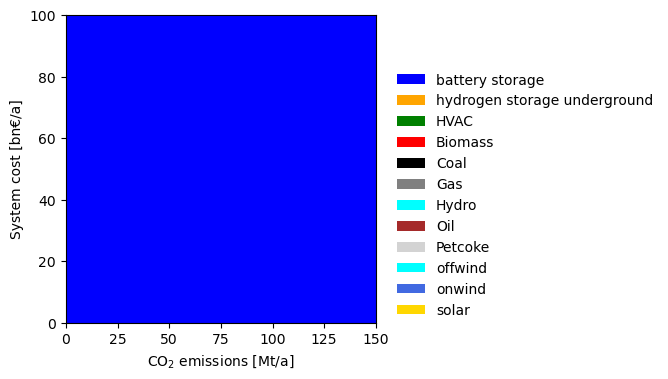

In [152]:
color_map = {
    'battery storage': 'blue', 
    'hydrogen storage underground': 'orange',
    
    'HVAC': 'green', 
    'Biomass': 'red',
    'Coal': 'black',
    'Gas': 'grey',
    'Hydro': 'cyan',
    'Oil': 'brown',
    'Petcoke': 'lightgrey',
    'offwind': 'cyan',
    'onwind': 'royalblue',
    'solar': 'gold'
    
}

colors = df.columns.map(lambda x: color_map[x])

# Plotting the area chart
df.plot.area(
    stacked=True,
    linewidth=0,
    color=colors,
    figsize=(4, 4),
    xlim=(0, 150),
    xlabel=r"CO$_2$ emissions [Mt/a]",
    ylabel="System cost [bn€/a]",
    ylim=(0, 100),
)

# Adjust legend
plt.legend(frameon=False, loc=(1.05, 0))

# Show plot
plt.show()

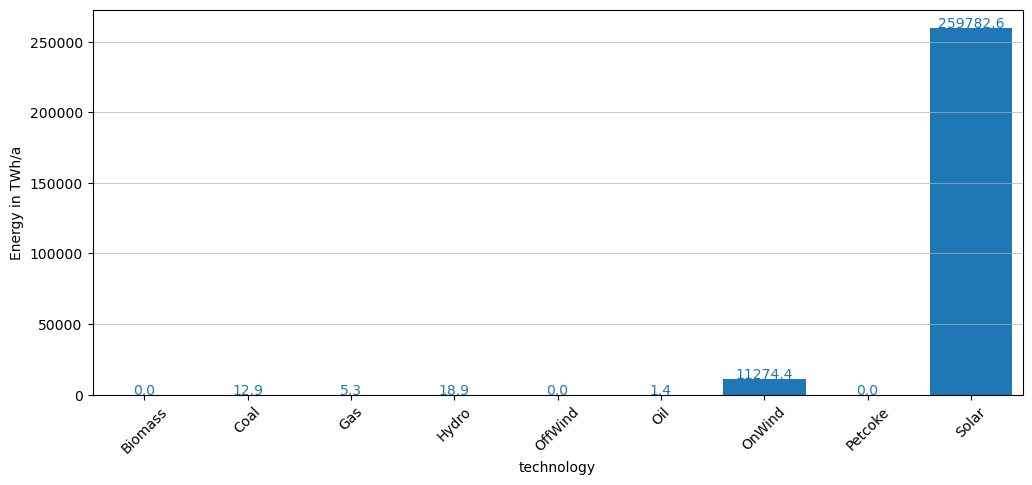

In [154]:
# Energy mix in Chile in 2050, TWh
gen = pd.DataFrame(n.snapshot_weightings.generators @ n.generators_t.p.div(1e6)) # TWh
gen["technology"] = gen.index.str.split(" ").str[-1]
result = gen.groupby("technology").sum()
result = result['generators']

fig, ax = plt.subplots(figsize=(12,5))
result.plot.bar()
ax.set_ylabel("Energy in TWh/a")
ax.grid(alpha=0.7, axis = 'y', linewidth = 0.7)
plt.xticks(rotation=45)
bars = ax.bar(
    x=np.arange(result.size),
    height=result,
)
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bars[0].get_facecolor(),
      #weight='bold'
  )

In [157]:
n.export_to_netcdf(r"GroupB_postnetwork.nc")

INFO:pypsa.io:Exported network GroupB_postnetwork.nc has global_constraints, storage_units, loads, links, buses, generators


<xarray.Dataset>
Dimensions:                               (snapshots: 2920,
                                           investment_periods: 0,
                                           global_constraints_i: 1,
                                           storage_units_i: 10,
                                           storage_units_t_p_i: 10,
                                           storage_units_t_p_dispatch_i: 10,
                                           ...
                                           links_t_p1_i: 4, buses_i: 7,
                                           buses_t_p_i: 5,
                                           buses_t_marginal_price_i: 6,
                                           generators_i: 27,
                                           generators_t_p_max_pu_i: 11,
                                           generators_t_p_i: 21)
Coordinates: (12/19)
  * snapshots                             (snapshots) int64 0 1 2 ... 2918 2919
  * investment_periods                    (investment_periods) int64 
  * global_constraints_i                  (global_constraints_i) object 'CO2L...
  * storage_units_i                       (storage_units_i) object 'CHL1 batt...
  * storage_units_t_p_i                   (storage_units_t_p_i) object 'CHL1 ...
  * storage_units_t_p_dispatch_i          (storage_units_t_p_dispatch_i) object ...
    ...                                    ...
  * buses_i                               (buses_i) object 'CHL1' ... 'Chile ...
  * buses_t_p_i                           (buses_t_p_i) object 'CHL1' ... 'CHL5'
  * buses_t_marginal_price_i              (buses_t_marginal_price_i) object '...
  * generators_i                          (generators_i) object 'CHL3 Biomass...
  * generators_t_p_max_pu_i               (generators_t_p_max_pu_i) object 'C...
  * generators_t_p_i                      (generators_t_p_i) object 'CHL2 Coa...
Data variables: (12/62)
    snapshots_snapshot                    (snapshots) datetime64[ns] 2013-01-...
    snapshots_objective                   (snapshots) float64 3.0 3.0 ... 3.0
    snapshots_stores                      (snapshots) float64 3.0 3.0 ... 3.0
    snapshots_generators                  (snapshots) float64 3.0 3.0 ... 3.0
    investment_periods_objective          (investment_periods) object 
    investment_periods_years              (investment_periods) object 
    ...                                    ...
    generators_min_down_time              (generators_i) int64 0 0 0 0 ... 0 0 0
    generators_up_time_before             (generators_i) int64 1 1 1 1 ... 1 1 1
    generators_down_time_before           (generators_i) int64 0 0 0 0 ... 0 0 0
    generators_p_nom_opt                  (generators_i) float64 302.9 ... 2....
    generators_t_p_max_pu                 (snapshots, generators_t_p_max_pu_i) float64 ...
    generators_t_p                        (snapshots, generators_t_p_i) float64 ...
Attributes:
    network__linearized_uc:  0
    network__multi_invest:   0
    network_name:            
    network_objective:       15426565476457.344
    network_pypsa_version:   0.25.1
    network_srid:            4326
    meta:                    {}